这个份文件多做了如下工作：

1、对价格列，异常值实在太离谱的，比如25w的，给予删除，然后用自动分箱处理异常值，以及需求量删除一些异常值


2、剔除掉（也可包含）区域104的数据，104仅有15年9月到16年12月数据，可剔除掉（因为最终预测目标里没有104区域的产品），可包含(特征工程均值编码、需求量趋势等)可以用来影响一下产品的大类、细类特性。，这里我选择保留，只是选择产品时和分区域模型预测时，跳过104区域

3、发现还有432个没有历史数据的新产品待预测

# 处理数据

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd 
import numpy as np 
import warnings
import datetime
from lightgbm import LGBMRegressor
from chinese_calendar import is_workday
import joblib
warnings.filterwarnings("ignore")

In [2]:

pd.options.display.max_columns=100 # to see columns 
df = pd.read_csv('process1.csv',encoding='utf-8')
df

,订单日期,销售区域编码,产品编码,产品大类编码,产品细类编码,销售渠道名称,产品价格,订单需求量,Year,Month,day,week,grade,标签,是否节假日
0,2015-09-01,104,22069,307,403,offline,1114.0,19,2015,9,1,36,较高价格,月初,0
1,2015-09-01,104,20028,301,405,offline,1012.0,12,2015,9,1,36,较高价格,月初,0
2,2015-09-02,104,21183,307,403,online,428.0,109,2015,9,2,36,低价格,月初,0
3,2015-09-02,104,20448,308,404,online,962.0,3,2015,9,2,36,较高价格,月初,0
4,2015-09-02,104,21565,307,403,offline,1400.0,3,2015,9,2,36,高价格,月初,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
597377,2018-12-20,102,20994,302,408,offline,843.0,59,2018,12,20,51,中价格,月中,0
597378,2018-12-20,102,21875,302,408,offline,762.0,502,2018,12,20,51,中价格,月中,0
597379,2018-12-20,102,20215,302,408,offline,2013.0,106,2018,12,20,51,高价格,月中,0
597380,2018-12-20,102,20195,302,408,offline,2120.0,187,2018,12,20,51,高价格,月中,0


In [3]:
df.isnull().sum()

订单日期      0
销售区域编码    0
产品编码      0
产品大类编码    0
产品细类编码    0
销售渠道名称    0
产品价格      0
订单需求量     0
Year      0
Month     0
day       0
week      0
grade     0
标签        0
是否节假日     0
dtype: int64

### 异常值简单处理

In [4]:
# 对价格异常值先删除一部分：
df.describe()

,销售区域编码,产品编码,产品大类编码,产品细类编码,产品价格,订单需求量,Year,Month,day,week,是否节假日
count,597382.000000,597382.000000,597382.000000,597382.000000,597382.000000,597382.000000,597382.000000,597382.000000,597382.000000,597382.000000,597382.000000
mean,102.904318,21008.029884,304.932141,406.457362,1076.141512,91.683901,2017.013372,7.060494,16.902210,29.025597,0.262392
std,1.505023,590.908646,2.004253,3.107303,1167.576590,199.887129,0.921979,3.503281,8.399885,15.298208,0.439935
min,101.000000,20001.000000,301.000000,401.000000,1.000000,1.000000,2015.000000,1.000000,1.000000,1.000000,0.000000
25%,102.000000,20518.000000,303.000000,404.000000,598.000000,10.000000,2016.000000,4.000000,10.000000,16.000000,0.000000
50%,103.000000,20976.000000,306.000000,407.000000,883.000000,29.000000,2017.000000,8.000000,17.000000,32.000000,0.000000
75%,105.000000,21521.000000,306.000000,408.000000,1291.000000,101.000000,2018.000000,10.000000,24.000000,43.000000,1.000000
max,105.000000,22084.000000,308.000000,412.000000,260014.000000,16308.000000,2018.000000,12.000000,31.000000,53.000000,1.000000


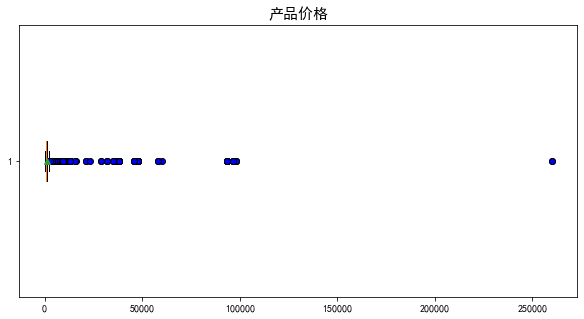

In [5]:
#产品价格特征异常值检查
plt.figure(figsize=(10,5))
plt.rcParams['font.sans-serif']='simhei'
plt.rcParams['axes.unicode_minus']=False
a1 = plt.boxplot(df['产品价格'],vert=False,showmeans=True,flierprops={"marker":"o","markerfacecolor":"blue"})
plt.title('产品价格',fontsize=15)
plt.savefig('产品价格箱线图.jpg',dpi=200)

In [6]:
df[df['产品价格'] >50000]   ###后面的分箱操作就是处理价格异常值的，不过在分箱的过程时，不能因为两个26万的产品而多分一个箱子，
#所以删除掉两个异常值
df=df[df['产品价格'] <100000] #用小于10万方式，去掉26万的异常值
df 
#删除产品价格大于100000的

,订单日期,销售区域编码,产品编码,产品大类编码,产品细类编码,销售渠道名称,产品价格,订单需求量,Year,Month,day,week,grade,标签,是否节假日
0,2015-09-01,104,22069,307,403,offline,1114.0,19,2015,9,1,36,较高价格,月初,0
1,2015-09-01,104,20028,301,405,offline,1012.0,12,2015,9,1,36,较高价格,月初,0
2,2015-09-02,104,21183,307,403,online,428.0,109,2015,9,2,36,低价格,月初,0
3,2015-09-02,104,20448,308,404,online,962.0,3,2015,9,2,36,较高价格,月初,0
4,2015-09-02,104,21565,307,403,offline,1400.0,3,2015,9,2,36,高价格,月初,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
597377,2018-12-20,102,20994,302,408,offline,843.0,59,2018,12,20,51,中价格,月中,0
597378,2018-12-20,102,21875,302,408,offline,762.0,502,2018,12,20,51,中价格,月中,0
597379,2018-12-20,102,20215,302,408,offline,2013.0,106,2018,12,20,51,高价格,月中,0
597380,2018-12-20,102,20195,302,408,offline,2120.0,187,2018,12,20,51,高价格,月中,0


Text(0.5, 1.0, '订单需求量')

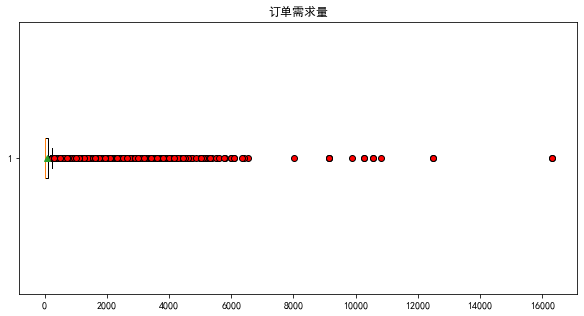

In [7]:
#再查看需求量异常值： 在df.describe()中可以知道需求量有max16308，
#产品价格特征异常值检查
plt.figure(figsize=(10,5))
plt.rcParams['font.sans-serif']='simhei'
plt.rcParams['axes.unicode_minus']=False
a1 = plt.boxplot(df['订单需求量'],vert=False,showmeans=True,flierprops={"marker":"o","markerfacecolor":"red"})
plt.title('订单需求量')


In [8]:
df[df['订单需求量'] >6000] 
df=df[df['订单需求量'] <6000]
df 
#删除单日需求量大于6000的

,订单日期,销售区域编码,产品编码,产品大类编码,产品细类编码,销售渠道名称,产品价格,订单需求量,Year,Month,day,week,grade,标签,是否节假日
0,2015-09-01,104,22069,307,403,offline,1114.0,19,2015,9,1,36,较高价格,月初,0
1,2015-09-01,104,20028,301,405,offline,1012.0,12,2015,9,1,36,较高价格,月初,0
2,2015-09-02,104,21183,307,403,online,428.0,109,2015,9,2,36,低价格,月初,0
3,2015-09-02,104,20448,308,404,online,962.0,3,2015,9,2,36,较高价格,月初,0
4,2015-09-02,104,21565,307,403,offline,1400.0,3,2015,9,2,36,高价格,月初,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
597377,2018-12-20,102,20994,302,408,offline,843.0,59,2018,12,20,51,中价格,月中,0
597378,2018-12-20,102,21875,302,408,offline,762.0,502,2018,12,20,51,中价格,月中,0
597379,2018-12-20,102,20215,302,408,offline,2013.0,106,2018,12,20,51,高价格,月中,0
597380,2018-12-20,102,20195,302,408,offline,2120.0,187,2018,12,20,51,高价格,月中,0


### 构造促销列

In [9]:
#自定义促销日期： 促销日有很多，我们随便选10个代表性的促销日期进行数据统计
list_cux = ['1-1','4-1','2-14','3-1','3-8','4-11','5-1','6-1','6-18','11-11','12-12']



cuxs=[]

#再得到日期是否是自己自定义的促销日：
for index ,row in df.iterrows():
    str_date = str(row['Month'])+'-'+str(row['day'])
    if str_date in list_cux:
#         print(str_date)
        cuxs.append(1)
    else:
        cuxs.append(0)


df['是否促销日']=cuxs
df

,订单日期,销售区域编码,产品编码,产品大类编码,产品细类编码,销售渠道名称,产品价格,订单需求量,Year,Month,day,week,grade,标签,是否节假日,是否促销日
0,2015-09-01,104,22069,307,403,offline,1114.0,19,2015,9,1,36,较高价格,月初,0,0
1,2015-09-01,104,20028,301,405,offline,1012.0,12,2015,9,1,36,较高价格,月初,0,0
2,2015-09-02,104,21183,307,403,online,428.0,109,2015,9,2,36,低价格,月初,0,0
3,2015-09-02,104,20448,308,404,online,962.0,3,2015,9,2,36,较高价格,月初,0,0
4,2015-09-02,104,21565,307,403,offline,1400.0,3,2015,9,2,36,高价格,月初,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
597377,2018-12-20,102,20994,302,408,offline,843.0,59,2018,12,20,51,中价格,月中,0,0
597378,2018-12-20,102,21875,302,408,offline,762.0,502,2018,12,20,51,中价格,月中,0,0
597379,2018-12-20,102,20215,302,408,offline,2013.0,106,2018,12,20,51,高价格,月中,0,0
597380,2018-12-20,102,20195,302,408,offline,2120.0,187,2018,12,20,51,高价格,月中,0,0


### 构造D列

In [10]:
dt1 = pd.date_range(start="20150901", end="20181220", freq="D")
dt1
dicts = {}
i =1
for date in dt1:
#     print(str(date).split(' ')[0])
    dicts[str(date).split(' ')[0]]=i
    i+=1
dicts
df['D'] = df['订单日期'].map(dicts)
df

,订单日期,销售区域编码,产品编码,产品大类编码,产品细类编码,销售渠道名称,产品价格,订单需求量,Year,Month,day,week,grade,标签,是否节假日,是否促销日,D
0,2015-09-01,104,22069,307,403,offline,1114.0,19,2015,9,1,36,较高价格,月初,0,0,1
1,2015-09-01,104,20028,301,405,offline,1012.0,12,2015,9,1,36,较高价格,月初,0,0,1
2,2015-09-02,104,21183,307,403,online,428.0,109,2015,9,2,36,低价格,月初,0,0,2
3,2015-09-02,104,20448,308,404,online,962.0,3,2015,9,2,36,较高价格,月初,0,0,2
4,2015-09-02,104,21565,307,403,offline,1400.0,3,2015,9,2,36,高价格,月初,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
597377,2018-12-20,102,20994,302,408,offline,843.0,59,2018,12,20,51,中价格,月中,0,0,1207
597378,2018-12-20,102,21875,302,408,offline,762.0,502,2018,12,20,51,中价格,月中,0,0,1207
597379,2018-12-20,102,20215,302,408,offline,2013.0,106,2018,12,20,51,高价格,月中,0,0,1207
597380,2018-12-20,102,20195,302,408,offline,2120.0,187,2018,12,20,51,高价格,月中,0,0,1207


In [11]:
len(set(df['产品编码']))

1758

In [12]:
len(set(df['产品价格']))

14362

### 重新对价格进行更细致的分箱编码

In [13]:
from scipy.stats import stats
def optimal_bins(Y,X,n):
    """
    :Y  目标变量
    ：X  待分箱特征
    ：n 分箱数初始值
    return : 统计值，分箱边界值列表、woe值、iv值
    """
    r = 0  #xia相关系数的初始值
    total_bad = Y.sum()  #总的坏样本数
    total_good = Y.count() - total_bad   #总的好样本数
    #分箱过程
    while np.abs(r) <1:   #相关系数的绝对值等于1结束循环，循环目的找寻最好正反相关性
        #df1中的bin为给X分箱对应的结果
        df1 = pd.DataFrame({'X':X,'Y':Y,'bin':pd.qcut(X,n,duplicates='drop')})  #drop表示删除重复元素
        #将df1基于箱子进行分组
        df2 = df1.groupby('bin')
        #r返回的是df1对箱子分组后，每组数据X的均值的相关系数，如果系数不为正负1，则减少分箱的箱数
        r,p = stats.spearmanr(df2.mean().X,df2.mean().Y) #计算相关系数
        n = n-1
    cut =[0]  #分箱边界值列表
    for i in range(1,n+2):  #i的取值范围是1->（n+1），n+1是分箱的数量
        qua = X.quantile(i/(n+1)) #quantile把给定的乱序的数值有小到大并列分成n等份，参数表述取出第百分之多少大小的数值
                                    #i的取值范围是1->n 1/n.2/n 3/n...n/n
        cut.append(round(qua,6))
   
    return cut
#对RevolvingRatio列进行分箱操作：
cut_bins = optimal_bins(df.订单需求量,df.产品价格,n=10)
cut_bins
df['价格区间'] = pd.cut(df['产品价格'],cut_bins,labels=[x for x in range(len(cut_bins)-1)])
df

,订单日期,销售区域编码,产品编码,产品大类编码,产品细类编码,销售渠道名称,产品价格,订单需求量,Year,Month,day,week,grade,标签,是否节假日,是否促销日,D,价格区间
0,2015-09-01,104,22069,307,403,offline,1114.0,19,2015,9,1,36,较高价格,月初,0,0,1,4
1,2015-09-01,104,20028,301,405,offline,1012.0,12,2015,9,1,36,较高价格,月初,0,0,1,4
2,2015-09-02,104,21183,307,403,online,428.0,109,2015,9,2,36,低价格,月初,0,0,2,0
3,2015-09-02,104,20448,308,404,online,962.0,3,2015,9,2,36,较高价格,月初,0,0,2,3
4,2015-09-02,104,21565,307,403,offline,1400.0,3,2015,9,2,36,高价格,月初,0,0,2,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
597377,2018-12-20,102,20994,302,408,offline,843.0,59,2018,12,20,51,中价格,月中,0,0,1207,3
597378,2018-12-20,102,21875,302,408,offline,762.0,502,2018,12,20,51,中价格,月中,0,0,1207,2
597379,2018-12-20,102,20215,302,408,offline,2013.0,106,2018,12,20,51,高价格,月中,0,0,1207,6
597380,2018-12-20,102,20195,302,408,offline,2120.0,187,2018,12,20,51,高价格,月中,0,0,1207,6


In [14]:
cut_bins

[0, 468.0, 645.0, 797.0, 969.557143, 1209.0, 1616.0, 98016.0]

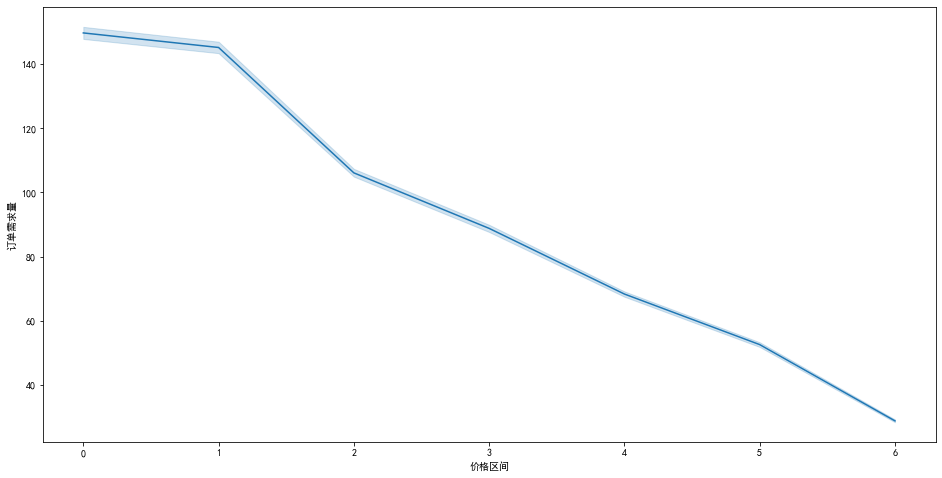

In [15]:
plt.figure(figsize=(16,8))
plt.rcParams['font.sans-serif']='simhei'
plt.rcParams['axes.unicode_minus']=False
sns.lineplot(x='价格区间', y='订单需求量', data=df)
plt.show()

###  利用map映射对“渠道”和“月头、月中..”编码处理

In [16]:
dict_qudao = {'offline':0,'online':1}
dict_moth = {'月初':0,'月中':1,'月末':2}
df.销售渠道名称 = df.销售渠道名称.map(dict_qudao)
df['每月时间段'] =df.标签.map(dict_moth)
df

,订单日期,销售区域编码,产品编码,产品大类编码,产品细类编码,销售渠道名称,产品价格,订单需求量,Year,Month,day,week,grade,标签,是否节假日,是否促销日,D,价格区间,每月时间段
0,2015-09-01,104,22069,307,403,0,1114.0,19,2015,9,1,36,较高价格,月初,0,0,1,4,0
1,2015-09-01,104,20028,301,405,0,1012.0,12,2015,9,1,36,较高价格,月初,0,0,1,4,0
2,2015-09-02,104,21183,307,403,1,428.0,109,2015,9,2,36,低价格,月初,0,0,2,0,0
3,2015-09-02,104,20448,308,404,1,962.0,3,2015,9,2,36,较高价格,月初,0,0,2,3,0
4,2015-09-02,104,21565,307,403,0,1400.0,3,2015,9,2,36,高价格,月初,0,0,2,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
597377,2018-12-20,102,20994,302,408,0,843.0,59,2018,12,20,51,中价格,月中,0,0,1207,3,1
597378,2018-12-20,102,21875,302,408,0,762.0,502,2018,12,20,51,中价格,月中,0,0,1207,2,1
597379,2018-12-20,102,20215,302,408,0,2013.0,106,2018,12,20,51,高价格,月中,0,0,1207,6,1
597380,2018-12-20,102,20195,302,408,0,2120.0,187,2018,12,20,51,高价格,月中,0,0,1207,6,1


### 根据第一问分析，需要对每个地区季节再进行分类和标签编码¶

In [17]:
df["season"] = df["Month"].map({3:"春季",4:"春季",5:"春季",6:"夏季",7:"夏季",
                                        8:"夏季",9:"秋季",10:"秋季",11:"秋季",12:"冬季",1:"冬季",2:"冬季"})
df
dict_season = {'春季':0,'夏季':1,'秋季':2,'冬季':3}
df['season_bm'] =df.season.map(dict_season)
df

,订单日期,销售区域编码,产品编码,产品大类编码,产品细类编码,销售渠道名称,产品价格,订单需求量,Year,Month,day,week,grade,标签,是否节假日,是否促销日,D,价格区间,每月时间段,season,season_bm
0,2015-09-01,104,22069,307,403,0,1114.0,19,2015,9,1,36,较高价格,月初,0,0,1,4,0,秋季,2
1,2015-09-01,104,20028,301,405,0,1012.0,12,2015,9,1,36,较高价格,月初,0,0,1,4,0,秋季,2
2,2015-09-02,104,21183,307,403,1,428.0,109,2015,9,2,36,低价格,月初,0,0,2,0,0,秋季,2
3,2015-09-02,104,20448,308,404,1,962.0,3,2015,9,2,36,较高价格,月初,0,0,2,3,0,秋季,2
4,2015-09-02,104,21565,307,403,0,1400.0,3,2015,9,2,36,高价格,月初,0,0,2,5,0,秋季,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
597377,2018-12-20,102,20994,302,408,0,843.0,59,2018,12,20,51,中价格,月中,0,0,1207,3,1,冬季,3
597378,2018-12-20,102,21875,302,408,0,762.0,502,2018,12,20,51,中价格,月中,0,0,1207,2,1,冬季,3
597379,2018-12-20,102,20215,302,408,0,2013.0,106,2018,12,20,51,高价格,月中,0,0,1207,6,1,冬季,3
597380,2018-12-20,102,20195,302,408,0,2120.0,187,2018,12,20,51,高价格,月中,0,0,1207,6,1,冬季,3


### 构造新特征，日期为每周星期几、工作日还是休息日

In [18]:

df['订单日期'] = pd.to_datetime(df['订单日期'])  #对日期列进行日期格式转换
df['星期几'] = df.订单日期.dt.weekday   #0-6  {0, 1, 2, 3, 4, 5, 6}
df

,订单日期,销售区域编码,产品编码,产品大类编码,产品细类编码,销售渠道名称,产品价格,订单需求量,Year,Month,day,week,grade,标签,是否节假日,是否促销日,D,价格区间,每月时间段,season,season_bm,星期几
0,2015-09-01,104,22069,307,403,0,1114.0,19,2015,9,1,36,较高价格,月初,0,0,1,4,0,秋季,2,1
1,2015-09-01,104,20028,301,405,0,1012.0,12,2015,9,1,36,较高价格,月初,0,0,1,4,0,秋季,2,1
2,2015-09-02,104,21183,307,403,1,428.0,109,2015,9,2,36,低价格,月初,0,0,2,0,0,秋季,2,2
3,2015-09-02,104,20448,308,404,1,962.0,3,2015,9,2,36,较高价格,月初,0,0,2,3,0,秋季,2,2
4,2015-09-02,104,21565,307,403,0,1400.0,3,2015,9,2,36,高价格,月初,0,0,2,5,0,秋季,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
597377,2018-12-20,102,20994,302,408,0,843.0,59,2018,12,20,51,中价格,月中,0,0,1207,3,1,冬季,3,3
597378,2018-12-20,102,21875,302,408,0,762.0,502,2018,12,20,51,中价格,月中,0,0,1207,2,1,冬季,3,3
597379,2018-12-20,102,20215,302,408,0,2013.0,106,2018,12,20,51,高价格,月中,0,0,1207,6,1,冬季,3,3
597380,2018-12-20,102,20195,302,408,0,2120.0,187,2018,12,20,51,高价格,月中,0,0,1207,6,1,冬季,3,3


In [19]:
df['is_workday']=df['订单日期'].map(lambda x:is_workday(x))
df
dict_is_workday = {False:0,True:1}
df['is_workday'] =df.is_workday.map(dict_is_workday)
df

,订单日期,销售区域编码,产品编码,产品大类编码,产品细类编码,销售渠道名称,产品价格,订单需求量,Year,Month,day,week,grade,标签,是否节假日,是否促销日,D,价格区间,每月时间段,season,season_bm,星期几,is_workday
0,2015-09-01,104,22069,307,403,0,1114.0,19,2015,9,1,36,较高价格,月初,0,0,1,4,0,秋季,2,1,1
1,2015-09-01,104,20028,301,405,0,1012.0,12,2015,9,1,36,较高价格,月初,0,0,1,4,0,秋季,2,1,1
2,2015-09-02,104,21183,307,403,1,428.0,109,2015,9,2,36,低价格,月初,0,0,2,0,0,秋季,2,2,1
3,2015-09-02,104,20448,308,404,1,962.0,3,2015,9,2,36,较高价格,月初,0,0,2,3,0,秋季,2,2,1
4,2015-09-02,104,21565,307,403,0,1400.0,3,2015,9,2,36,高价格,月初,0,0,2,5,0,秋季,2,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
597377,2018-12-20,102,20994,302,408,0,843.0,59,2018,12,20,51,中价格,月中,0,0,1207,3,1,冬季,3,3,1
597378,2018-12-20,102,21875,302,408,0,762.0,502,2018,12,20,51,中价格,月中,0,0,1207,2,1,冬季,3,3,1
597379,2018-12-20,102,20215,302,408,0,2013.0,106,2018,12,20,51,高价格,月中,0,0,1207,6,1,冬季,3,3,1
597380,2018-12-20,102,20195,302,408,0,2120.0,187,2018,12,20,51,高价格,月中,0,0,1207,6,1,冬季,3,3,1


### 删除无用列，整理df

In [20]:
df.drop(['产品价格','week','grade','标签','season'],axis=1,inplace=True)
df

,订单日期,销售区域编码,产品编码,产品大类编码,产品细类编码,销售渠道名称,订单需求量,Year,Month,day,是否节假日,是否促销日,D,价格区间,每月时间段,season_bm,星期几,is_workday
0,2015-09-01,104,22069,307,403,0,19,2015,9,1,0,0,1,4,0,2,1,1
1,2015-09-01,104,20028,301,405,0,12,2015,9,1,0,0,1,4,0,2,1,1
2,2015-09-02,104,21183,307,403,1,109,2015,9,2,0,0,2,0,0,2,2,1
3,2015-09-02,104,20448,308,404,1,3,2015,9,2,0,0,2,3,0,2,2,1
4,2015-09-02,104,21565,307,403,0,3,2015,9,2,0,0,2,5,0,2,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
597377,2018-12-20,102,20994,302,408,0,59,2018,12,20,0,0,1207,3,1,3,3,1
597378,2018-12-20,102,21875,302,408,0,502,2018,12,20,0,0,1207,2,1,3,3,1
597379,2018-12-20,102,20215,302,408,0,106,2018,12,20,0,0,1207,6,1,3,3,1
597380,2018-12-20,102,20195,302,408,0,187,2018,12,20,0,0,1207,6,1,3,3,1


In [21]:
df.to_csv("data/proess_transform.csv",index=False)  #保存数据，用于后续预测出19-01年数据后进行拼接，将19-01月数据添加在这个数据后
#作为训练集。再去预测19-02月的数据。

In [22]:
df.info()  #下面构造的时候，也需要最后转为同样的类型

<class 'pandas.core.frame.DataFrame'>
Int64Index: 597361 entries, 0 to 597381
Data columns (total 18 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   订单日期        597361 non-null  datetime64[ns]
 1   销售区域编码      597361 non-null  int64         
 2   产品编码        597361 non-null  int64         
 3   产品大类编码      597361 non-null  int64         
 4   产品细类编码      597361 non-null  int64         
 5   销售渠道名称      597361 non-null  int64         
 6   订单需求量       597361 non-null  int64         
 7   Year        597361 non-null  int64         
 8   Month       597361 non-null  int64         
 9   day         597361 non-null  int64         
 10  是否节假日       597361 non-null  int64         
 11  是否促销日       597361 non-null  int64         
 12  D           597361 non-null  int64         
 13  价格区间        597361 non-null  category      
 14  每月时间段       597361 non-null  int64         
 15  season_bm   597361 non-null  int64         
 16  星期

### 增加待预测的三个月数据（2019年1,2,3,月）

In [23]:
#在 构造待预测数据之前，我们先剔除掉104地区的数据，因为不需要对该数据预测

temp = df[df['销售区域编码']!=104]
temp #减少了2w多数据



,订单日期,销售区域编码,产品编码,产品大类编码,产品细类编码,销售渠道名称,订单需求量,Year,Month,day,是否节假日,是否促销日,D,价格区间,每月时间段,season_bm,星期几,is_workday
8,2015-09-02,102,20323,305,412,0,502,2015,9,2,0,0,2,0,0,2,2,1
9,2015-09-02,102,21350,305,412,0,107,2015,9,2,0,0,2,0,0,2,2,1
10,2015-09-02,101,20657,303,410,0,18,2015,9,2,0,0,2,6,0,2,2,1
11,2015-09-02,102,20457,305,412,0,308,2015,9,2,0,0,2,0,0,2,2,1
12,2015-09-03,102,21052,303,401,0,14,2015,9,3,1,0,3,5,0,2,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
597377,2018-12-20,102,20994,302,408,0,59,2018,12,20,0,0,1207,3,1,3,3,1
597378,2018-12-20,102,21875,302,408,0,502,2018,12,20,0,0,1207,2,1,3,3,1
597379,2018-12-20,102,20215,302,408,0,106,2018,12,20,0,0,1207,6,1,3,3,1
597380,2018-12-20,102,20195,302,408,0,187,2018,12,20,0,0,1207,6,1,3,3,1


In [24]:

temp['组合'] = temp['销售区域编码'].astype(str)+'_'+temp['产品大类编码'].astype(str)+'_'+temp['产品细类编码'].astype(str)+'_'+temp['产品编码'].astype(str)
temp


,订单日期,销售区域编码,产品编码,产品大类编码,产品细类编码,销售渠道名称,订单需求量,Year,Month,day,是否节假日,是否促销日,D,价格区间,每月时间段,season_bm,星期几,is_workday,组合
8,2015-09-02,102,20323,305,412,0,502,2015,9,2,0,0,2,0,0,2,2,1,102_305_412_20323
9,2015-09-02,102,21350,305,412,0,107,2015,9,2,0,0,2,0,0,2,2,1,102_305_412_21350
10,2015-09-02,101,20657,303,410,0,18,2015,9,2,0,0,2,6,0,2,2,1,101_303_410_20657
11,2015-09-02,102,20457,305,412,0,308,2015,9,2,0,0,2,0,0,2,2,1,102_305_412_20457
12,2015-09-03,102,21052,303,401,0,14,2015,9,3,1,0,3,5,0,2,3,0,102_303_401_21052
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
597377,2018-12-20,102,20994,302,408,0,59,2018,12,20,0,0,1207,3,1,3,3,1,102_302_408_20994
597378,2018-12-20,102,21875,302,408,0,502,2018,12,20,0,0,1207,2,1,3,3,1,102_302_408_21875
597379,2018-12-20,102,20215,302,408,0,106,2018,12,20,0,0,1207,6,1,3,3,1,102_302_408_20215
597380,2018-12-20,102,20195,302,408,0,187,2018,12,20,0,0,1207,6,1,3,3,1,102_302_408_20195


In [25]:
len(set(temp['组合'])) ## 完整给出的数据，剔除掉104区域后，有5109种产品，我们将先构造一下这5109种产品，每天的需求量为0，加入到原数据中
#先预测一个月的，再将一个月的数据加入到原始作为训练集，再去预测第二个月的，
#意思是先预测出5109种产品2019-1月的需求量，再去预测2019-2，最后时2019-3月。


#没去除104之前，产品有5366种，去掉后有5109种

5109

In [26]:
#从2018-12-21到2019-1-31日的数据

dt1 = pd.date_range(start="20181221", end="20190131", freq="D")
dt1
len(dt1)


42

In [27]:
dates=[]
need=[]
ids =[]
for d in dt1:
    date = str(d).split(' ')[0] #得到日期xx-xx-xx
    dates=dates+[date]*len(set(temp['组合']))
    need = need+[0]*len(set(temp['组合']))
    ids=ids+list(set(temp['组合']))
    

In [28]:
tempdf=pd.DataFrame()
tempdf['订单日期']=dates
tempdf['组合']=ids
tempdf['订单需求量']=need
tempdf  

,订单日期,组合,订单需求量
0,2018-12-21,102_306_407_21023,0
1,2018-12-21,101_308_404_20877,0
2,2018-12-21,105_308_404_20347,0
3,2018-12-21,102_303_401_20173,0
4,2018-12-21,101_305_412_20285,0
...,...,...,...
214573,2019-01-31,103_303_401_20135,0
214574,2019-01-31,105_302_408_20171,0
214575,2019-01-31,105_306_407_20093,0
214576,2019-01-31,103_308_404_21895,0


### chu处理tempdf为df的数据格式：

In [29]:
## chu处理tempdf为df的数据格式：

tempdf['销售区域编码']=tempdf['组合'].str.split('_',expand=True)[0]
tempdf['产品大类编码']=tempdf['组合'].str.split('_',expand=True)[1]
tempdf['产品细类编码']=tempdf['组合'].str.split('_',expand=True)[2]
tempdf['产品编码']=tempdf['组合'].str.split('_',expand=True)[3]
tempdf

,订单日期,组合,订单需求量,销售区域编码,产品大类编码,产品细类编码,产品编码
0,2018-12-21,102_306_407_21023,0,102,306,407,21023
1,2018-12-21,101_308_404_20877,0,101,308,404,20877
2,2018-12-21,105_308_404_20347,0,105,308,404,20347
3,2018-12-21,102_303_401_20173,0,102,303,401,20173
4,2018-12-21,101_305_412_20285,0,101,305,412,20285
...,...,...,...,...,...,...,...
214573,2019-01-31,103_303_401_20135,0,103,303,401,20135
214574,2019-01-31,105_302_408_20171,0,105,302,408,20171
214575,2019-01-31,105_306_407_20093,0,105,306,407,20093
214576,2019-01-31,103_308_404_21895,0,103,308,404,21895


In [30]:
## 
import chinese_calendar
import datetime

tempdf['订单日期'] = pd.to_datetime(tempdf['订单日期'])  #对日期列进行日期格式转换
tempdf['Year'] = tempdf.订单日期.dt.year #分解出年份
tempdf['Month'] = tempdf.订单日期.dt.month
tempdf['day'] = tempdf.订单日期.dt.day

tempdf

import datetime
from chinese_calendar import is_holiday, is_workday
is_holidays =[]  #用来存放日期是否为节假日。1为是，0为不是
for index,row in tempdf.iterrows():
    day = datetime.date(int(row['Year']), int(row['Month']),int(row['day']))
    if is_holiday(day):
        is_holidays.append(1)
    else:
        is_holidays.append(0)
tempdf['是否节假日'] = is_holidays  #加入到表格汇总
tempdf

## 去掉104区域的产品，我们构造的待预测的数据集，从225372 降为214578  

,订单日期,组合,订单需求量,销售区域编码,产品大类编码,产品细类编码,产品编码,Year,Month,day,是否节假日
0,2018-12-21,102_306_407_21023,0,102,306,407,21023,2018,12,21,0
1,2018-12-21,101_308_404_20877,0,101,308,404,20877,2018,12,21,0
2,2018-12-21,105_308_404_20347,0,105,308,404,20347,2018,12,21,0
3,2018-12-21,102_303_401_20173,0,102,303,401,20173,2018,12,21,0
4,2018-12-21,101_305_412_20285,0,101,305,412,20285,2018,12,21,0
...,...,...,...,...,...,...,...,...,...,...,...
214573,2019-01-31,103_303_401_20135,0,103,303,401,20135,2019,1,31,0
214574,2019-01-31,105_302_408_20171,0,105,302,408,20171,2019,1,31,0
214575,2019-01-31,105_306_407_20093,0,105,306,407,20093,2019,1,31,0
214576,2019-01-31,103_308_404_21895,0,103,308,404,21895,2019,1,31,0


In [31]:
#自定义促销日期： 促销日有很多，我们随便选10个代表性的促销日期进行数据统计
list_cux = ['1-1','4-1','2-14','3-1','3-8','4-11','5-1','6-1','6-18','11-11','12-12']
cuxs=[]

#再得到日期是否是自己自定义的促销日：
for index ,row in tempdf.iterrows():
    str_date = str(row['Month'])+'-'+str(row['day'])
    if str_date in list_cux:
#         print(str_date)
        cuxs.append(1)
    else:
        cuxs.append(0)


tempdf['是否促销日']=cuxs
tempdf

,订单日期,组合,订单需求量,销售区域编码,产品大类编码,产品细类编码,产品编码,Year,Month,day,是否节假日,是否促销日
0,2018-12-21,102_306_407_21023,0,102,306,407,21023,2018,12,21,0,0
1,2018-12-21,101_308_404_20877,0,101,308,404,20877,2018,12,21,0,0
2,2018-12-21,105_308_404_20347,0,105,308,404,20347,2018,12,21,0,0
3,2018-12-21,102_303_401_20173,0,102,303,401,20173,2018,12,21,0,0
4,2018-12-21,101_305_412_20285,0,101,305,412,20285,2018,12,21,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
214573,2019-01-31,103_303_401_20135,0,103,303,401,20135,2019,1,31,0,0
214574,2019-01-31,105_302_408_20171,0,105,302,408,20171,2019,1,31,0,0
214575,2019-01-31,105_306_407_20093,0,105,306,407,20093,2019,1,31,0,0
214576,2019-01-31,103_308_404_21895,0,103,308,404,21895,2019,1,31,0,0


In [32]:
jagdf=temp[['组合','价格区间','销售渠道名称']]
jagdf.drop_duplicates(['组合'],keep='last',inplace=True)
jagdf

,组合,价格区间,销售渠道名称
52,101_306_407_21604,5,0
1172,102_306_402_21645,0,0
2003,102_302_408_21112,4,0
2258,105_306_407_20556,4,0
2261,105_306_407_21353,6,0
...,...,...,...
597377,102_302_408_20994,3,0
597378,102_302_408_21875,2,0
597379,102_302_408_20215,6,0
597380,102_302_408_20195,6,0


In [33]:
dict_jg = {}
qudao_dict={}
for i in range(len(jagdf)):
    dict_jg[list(jagdf['组合'])[i]]=list(jagdf['价格区间'])[i]
    qudao_dict[list(jagdf['组合'])[i]] = list(jagdf['销售渠道名称'])[i]
dict_jg
qudao_dict

{'101_306_407_21604': 0,
 '102_306_402_21645': 0,
 '102_302_408_21112': 0,
 '105_306_407_20556': 0,
 '105_306_407_21353': 0,
 '105_306_407_20883': 0,
 '105_306_407_21020': 0,
 '103_305_412_22062': 0,
 '102_306_407_20326': 0,
 '102_306_407_21952': 0,
 '101_306_407_21976': 0,
 '103_306_407_21401': 0,
 '103_306_407_21949': 0,
 '101_306_407_21079': 0,
 '102_302_408_21273': 0,
 '102_303_401_20435': 0,
 '103_303_401_20072': 0,
 '101_306_407_20622': 0,
 '103_302_408_21263': 0,
 '101_306_407_21275': 0,
 '102_302_408_21024': 0,
 '102_302_408_21351': 0,
 '102_302_408_20019': 0,
 '103_303_401_20372': 0,
 '102_302_408_21471': 0,
 '105_306_407_21976': 0,
 '105_305_412_20603': 0,
 '105_303_401_21499': 0,
 '103_306_407_20855': 0,
 '103_306_407_21747': 0,
 '102_306_407_21448': 0,
 '105_305_412_21673': 1,
 '102_306_407_20493': 0,
 '102_303_401_20372': 0,
 '101_306_407_21448': 0,
 '105_306_407_20348': 0,
 '105_306_407_20659': 0,
 '105_306_407_20441': 1,
 '103_306_407_21604': 0,
 '101_302_408_20765': 0,


In [34]:
#价格区间：
jiage=[]
qudao =[]
for v in tempdf['组合']:
    jiage.append(dict_jg[v])
    qudao.append(qudao_dict[v])
tempdf['价格区间']=jiage
tempdf['销售渠道名称']=qudao
tempdf


,订单日期,组合,订单需求量,销售区域编码,产品大类编码,产品细类编码,产品编码,Year,Month,day,是否节假日,是否促销日,价格区间,销售渠道名称
0,2018-12-21,102_306_407_21023,0,102,306,407,21023,2018,12,21,0,0,6,0
1,2018-12-21,101_308_404_20877,0,101,308,404,20877,2018,12,21,0,0,2,0
2,2018-12-21,105_308_404_20347,0,105,308,404,20347,2018,12,21,0,0,2,0
3,2018-12-21,102_303_401_20173,0,102,303,401,20173,2018,12,21,0,0,1,1
4,2018-12-21,101_305_412_20285,0,101,305,412,20285,2018,12,21,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214573,2019-01-31,103_303_401_20135,0,103,303,401,20135,2019,1,31,0,0,2,0
214574,2019-01-31,105_302_408_20171,0,105,302,408,20171,2019,1,31,0,0,6,1
214575,2019-01-31,105_306_407_20093,0,105,306,407,20093,2019,1,31,0,0,2,0
214576,2019-01-31,103_308_404_21895,0,103,308,404,21895,2019,1,31,0,0,6,0


In [35]:
tempdf['标签'] = "空"


for index,row in tempdf.iterrows():
    ts = pd.Timestamp(row['Year'],row['Month'],row['day'])
    end=ts+pd.offsets.MonthEnd()
    if row['订单日期'] < pd.to_datetime(end) and row['订单日期'] <=pd.to_datetime(pd.Timestamp(row['Year'],row['Month'],10)):
        tempdf.at[index,'标签'] = "月初"
    elif pd.to_datetime(pd.Timestamp(row['Year'], row['Month'],10))< row['订单日期']  <=pd.to_datetime(pd.Timestamp(row['Year'],row['Month'],20)):
        tempdf.at[index,'标签'] = "月中" 
    else:
        tempdf.at[index,'标签'] = "月末" 
                        
tempdf


,订单日期,组合,订单需求量,销售区域编码,产品大类编码,产品细类编码,产品编码,Year,Month,day,是否节假日,是否促销日,价格区间,销售渠道名称,标签
0,2018-12-21,102_306_407_21023,0,102,306,407,21023,2018,12,21,0,0,6,0,月末
1,2018-12-21,101_308_404_20877,0,101,308,404,20877,2018,12,21,0,0,2,0,月末
2,2018-12-21,105_308_404_20347,0,105,308,404,20347,2018,12,21,0,0,2,0,月末
3,2018-12-21,102_303_401_20173,0,102,303,401,20173,2018,12,21,0,0,1,1,月末
4,2018-12-21,101_305_412_20285,0,101,305,412,20285,2018,12,21,0,0,0,1,月末
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214573,2019-01-31,103_303_401_20135,0,103,303,401,20135,2019,1,31,0,0,2,0,月末
214574,2019-01-31,105_302_408_20171,0,105,302,408,20171,2019,1,31,0,0,6,1,月末
214575,2019-01-31,105_306_407_20093,0,105,306,407,20093,2019,1,31,0,0,2,0,月末
214576,2019-01-31,103_308_404_21895,0,103,308,404,21895,2019,1,31,0,0,6,0,月末


In [36]:
tempdf["season"] = tempdf["Month"].map({3:"春季",4:"春季",5:"春季",6:"夏季",7:"夏季",
                                        8:"夏季",9:"秋季",10:"秋季",11:"秋季",12:"冬季",1:"冬季",2:"冬季"})

In [37]:
dict_season = {'春季':0,'夏季':1,'秋季':2,'冬季':3}
tempdf['season_bm'] =tempdf.season.map(dict_season)
tempdf
dict_moth = {'月初':0,'月中':1,'月末':2}
tempdf['每月时间段'] =tempdf.标签.map(dict_moth)
tempdf

,订单日期,组合,订单需求量,销售区域编码,产品大类编码,产品细类编码,产品编码,Year,Month,day,是否节假日,是否促销日,价格区间,销售渠道名称,标签,season,season_bm,每月时间段
0,2018-12-21,102_306_407_21023,0,102,306,407,21023,2018,12,21,0,0,6,0,月末,冬季,3,2
1,2018-12-21,101_308_404_20877,0,101,308,404,20877,2018,12,21,0,0,2,0,月末,冬季,3,2
2,2018-12-21,105_308_404_20347,0,105,308,404,20347,2018,12,21,0,0,2,0,月末,冬季,3,2
3,2018-12-21,102_303_401_20173,0,102,303,401,20173,2018,12,21,0,0,1,1,月末,冬季,3,2
4,2018-12-21,101_305_412_20285,0,101,305,412,20285,2018,12,21,0,0,0,1,月末,冬季,3,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214573,2019-01-31,103_303_401_20135,0,103,303,401,20135,2019,1,31,0,0,2,0,月末,冬季,3,2
214574,2019-01-31,105_302_408_20171,0,105,302,408,20171,2019,1,31,0,0,6,1,月末,冬季,3,2
214575,2019-01-31,105_306_407_20093,0,105,306,407,20093,2019,1,31,0,0,2,0,月末,冬季,3,2
214576,2019-01-31,103_308_404_21895,0,103,308,404,21895,2019,1,31,0,0,6,0,月末,冬季,3,2


In [38]:

tempdf['星期几'] = tempdf.订单日期.dt.weekday   #0-6  {0, 1, 2, 3, 4, 5, 6}

tempdf['is_workday']=tempdf['订单日期'].map(lambda x:is_workday(x))

dict_is_workday = {False:0,True:1}
tempdf['is_workday'] =tempdf.is_workday.map(dict_is_workday)
tempdf

,订单日期,组合,订单需求量,销售区域编码,产品大类编码,产品细类编码,产品编码,Year,Month,day,是否节假日,是否促销日,价格区间,销售渠道名称,标签,season,season_bm,每月时间段,星期几,is_workday
0,2018-12-21,102_306_407_21023,0,102,306,407,21023,2018,12,21,0,0,6,0,月末,冬季,3,2,4,1
1,2018-12-21,101_308_404_20877,0,101,308,404,20877,2018,12,21,0,0,2,0,月末,冬季,3,2,4,1
2,2018-12-21,105_308_404_20347,0,105,308,404,20347,2018,12,21,0,0,2,0,月末,冬季,3,2,4,1
3,2018-12-21,102_303_401_20173,0,102,303,401,20173,2018,12,21,0,0,1,1,月末,冬季,3,2,4,1
4,2018-12-21,101_305_412_20285,0,101,305,412,20285,2018,12,21,0,0,0,1,月末,冬季,3,2,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214573,2019-01-31,103_303_401_20135,0,103,303,401,20135,2019,1,31,0,0,2,0,月末,冬季,3,2,3,1
214574,2019-01-31,105_302_408_20171,0,105,302,408,20171,2019,1,31,0,0,6,1,月末,冬季,3,2,3,1
214575,2019-01-31,105_306_407_20093,0,105,306,407,20093,2019,1,31,0,0,2,0,月末,冬季,3,2,3,1
214576,2019-01-31,103_308_404_21895,0,103,308,404,21895,2019,1,31,0,0,6,0,月末,冬季,3,2,3,1


In [39]:
tempdf.drop(['标签','season','组合'],axis=1,inplace=True)

In [40]:
tempdf

,订单日期,订单需求量,销售区域编码,产品大类编码,产品细类编码,产品编码,Year,Month,day,是否节假日,是否促销日,价格区间,销售渠道名称,season_bm,每月时间段,星期几,is_workday
0,2018-12-21,0,102,306,407,21023,2018,12,21,0,0,6,0,3,2,4,1
1,2018-12-21,0,101,308,404,20877,2018,12,21,0,0,2,0,3,2,4,1
2,2018-12-21,0,105,308,404,20347,2018,12,21,0,0,2,0,3,2,4,1
3,2018-12-21,0,102,303,401,20173,2018,12,21,0,0,1,1,3,2,4,1
4,2018-12-21,0,101,305,412,20285,2018,12,21,0,0,0,1,3,2,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214573,2019-01-31,0,103,303,401,20135,2019,1,31,0,0,2,0,3,2,3,1
214574,2019-01-31,0,105,302,408,20171,2019,1,31,0,0,6,1,3,2,3,1
214575,2019-01-31,0,105,306,407,20093,2019,1,31,0,0,2,0,3,2,3,1
214576,2019-01-31,0,103,308,404,21895,2019,1,31,0,0,6,0,3,2,3,1


In [41]:
dt1 = pd.date_range(start="20150901", end="20190131", freq="D")
dt1
dicts = {}
i =1
for date in dt1:
#     print(str(date).split(' ')[0])
    dicts[str(date).split(' ')[0]]=i
    i+=1
dicts
Ds=[]
for dat in tempdf['订单日期']:
#     print(dicts[str(dat).split(' ')[0]])
    Ds.append(dicts[str(dat).split(' ')[0]])
tempdf['D'] = Ds
tempdf

,订单日期,订单需求量,销售区域编码,产品大类编码,产品细类编码,产品编码,Year,Month,day,是否节假日,是否促销日,价格区间,销售渠道名称,season_bm,每月时间段,星期几,is_workday,D
0,2018-12-21,0,102,306,407,21023,2018,12,21,0,0,6,0,3,2,4,1,1208
1,2018-12-21,0,101,308,404,20877,2018,12,21,0,0,2,0,3,2,4,1,1208
2,2018-12-21,0,105,308,404,20347,2018,12,21,0,0,2,0,3,2,4,1,1208
3,2018-12-21,0,102,303,401,20173,2018,12,21,0,0,1,1,3,2,4,1,1208
4,2018-12-21,0,101,305,412,20285,2018,12,21,0,0,0,1,3,2,4,1,1208
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214573,2019-01-31,0,103,303,401,20135,2019,1,31,0,0,2,0,3,2,3,1,1249
214574,2019-01-31,0,105,302,408,20171,2019,1,31,0,0,6,1,3,2,3,1,1249
214575,2019-01-31,0,105,306,407,20093,2019,1,31,0,0,2,0,3,2,3,1,1249
214576,2019-01-31,0,103,308,404,21895,2019,1,31,0,0,6,0,3,2,3,1,1249


In [42]:
df_sub=tempdf[['订单日期', '销售区域编码', '产品编码', '产品大类编码', '产品细类编码', '销售渠道名称', '订单需求量', 'Year',
       'Month', 'day', '是否节假日', '是否促销日', 'D', '价格区间', '每月时间段', 'season_bm',
       '星期几', 'is_workday',]]
df_sub

,订单日期,销售区域编码,产品编码,产品大类编码,产品细类编码,销售渠道名称,订单需求量,Year,Month,day,是否节假日,是否促销日,D,价格区间,每月时间段,season_bm,星期几,is_workday
0,2018-12-21,102,21023,306,407,0,0,2018,12,21,0,0,1208,6,2,3,4,1
1,2018-12-21,101,20877,308,404,0,0,2018,12,21,0,0,1208,2,2,3,4,1
2,2018-12-21,105,20347,308,404,0,0,2018,12,21,0,0,1208,2,2,3,4,1
3,2018-12-21,102,20173,303,401,1,0,2018,12,21,0,0,1208,1,2,3,4,1
4,2018-12-21,101,20285,305,412,1,0,2018,12,21,0,0,1208,0,2,3,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214573,2019-01-31,103,20135,303,401,0,0,2019,1,31,0,0,1249,2,2,3,3,1
214574,2019-01-31,105,20171,302,408,1,0,2019,1,31,0,0,1249,6,2,3,3,1
214575,2019-01-31,105,20093,306,407,0,0,2019,1,31,0,0,1249,2,2,3,3,1
214576,2019-01-31,103,21895,308,404,0,0,2019,1,31,0,0,1249,6,2,3,3,1


In [43]:
df_sub.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214578 entries, 0 to 214577
Data columns (total 18 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   订单日期        214578 non-null  datetime64[ns]
 1   销售区域编码      214578 non-null  object        
 2   产品编码        214578 non-null  object        
 3   产品大类编码      214578 non-null  object        
 4   产品细类编码      214578 non-null  object        
 5   销售渠道名称      214578 non-null  int64         
 6   订单需求量       214578 non-null  int64         
 7   Year        214578 non-null  int64         
 8   Month       214578 non-null  int64         
 9   day         214578 non-null  int64         
 10  是否节假日       214578 non-null  int64         
 11  是否促销日       214578 non-null  int64         
 12  D           214578 non-null  int64         
 13  价格区间        214578 non-null  int64         
 14  每月时间段       214578 non-null  int64         
 15  season_bm   214578 non-null  int64         
 16  星期

In [44]:

df_sub[['销售区域编码','产品编码','产品大类编码','产品细类编码',]] = df_sub[['销售区域编码','产品编码','产品大类编码','产品细类编码',]].apply(pd.to_numeric)
df_sub['价格区间']=df_sub['价格区间'].astype('category')
df_sub.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214578 entries, 0 to 214577
Data columns (total 18 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   订单日期        214578 non-null  datetime64[ns]
 1   销售区域编码      214578 non-null  int64         
 2   产品编码        214578 non-null  int64         
 3   产品大类编码      214578 non-null  int64         
 4   产品细类编码      214578 non-null  int64         
 5   销售渠道名称      214578 non-null  int64         
 6   订单需求量       214578 non-null  int64         
 7   Year        214578 non-null  int64         
 8   Month       214578 non-null  int64         
 9   day         214578 non-null  int64         
 10  是否节假日       214578 non-null  int64         
 11  是否促销日       214578 non-null  int64         
 12  D           214578 non-null  int64         
 13  价格区间        214578 non-null  category      
 14  每月时间段       214578 non-null  int64         
 15  season_bm   214578 non-null  int64         
 16  星期

In [45]:
# b保存一下构造的19年1月数据：
df_sub.to_csv('data/构造19_01data.csv',index=False,)

In [46]:
df

,订单日期,销售区域编码,产品编码,产品大类编码,产品细类编码,销售渠道名称,订单需求量,Year,Month,day,是否节假日,是否促销日,D,价格区间,每月时间段,season_bm,星期几,is_workday
0,2015-09-01,104,22069,307,403,0,19,2015,9,1,0,0,1,4,0,2,1,1
1,2015-09-01,104,20028,301,405,0,12,2015,9,1,0,0,1,4,0,2,1,1
2,2015-09-02,104,21183,307,403,1,109,2015,9,2,0,0,2,0,0,2,2,1
3,2015-09-02,104,20448,308,404,1,3,2015,9,2,0,0,2,3,0,2,2,1
4,2015-09-02,104,21565,307,403,0,3,2015,9,2,0,0,2,5,0,2,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
597377,2018-12-20,102,20994,302,408,0,59,2018,12,20,0,0,1207,3,1,3,3,1
597378,2018-12-20,102,21875,302,408,0,502,2018,12,20,0,0,1207,2,1,3,3,1
597379,2018-12-20,102,20215,302,408,0,106,2018,12,20,0,0,1207,6,1,3,3,1
597380,2018-12-20,102,20195,302,408,0,187,2018,12,20,0,0,1207,6,1,3,3,1


In [47]:
#拼接df_sub和df：

df1 =pd.concat([df,df_sub],axis=0)
df1

,订单日期,销售区域编码,产品编码,产品大类编码,产品细类编码,销售渠道名称,订单需求量,Year,Month,day,是否节假日,是否促销日,D,价格区间,每月时间段,season_bm,星期几,is_workday
0,2015-09-01,104,22069,307,403,0,19,2015,9,1,0,0,1,4,0,2,1,1
1,2015-09-01,104,20028,301,405,0,12,2015,9,1,0,0,1,4,0,2,1,1
2,2015-09-02,104,21183,307,403,1,109,2015,9,2,0,0,2,0,0,2,2,1
3,2015-09-02,104,20448,308,404,1,3,2015,9,2,0,0,2,3,0,2,2,1
4,2015-09-02,104,21565,307,403,0,3,2015,9,2,0,0,2,5,0,2,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214573,2019-01-31,103,20135,303,401,0,0,2019,1,31,0,0,1249,2,2,3,3,1
214574,2019-01-31,105,20171,302,408,1,0,2019,1,31,0,0,1249,6,2,3,3,1
214575,2019-01-31,105,20093,306,407,0,0,2019,1,31,0,0,1249,2,2,3,3,1
214576,2019-01-31,103,21895,308,404,0,0,2019,1,31,0,0,1249,6,2,3,3,1


In [48]:
df=df1
df = df.reset_index(drop=True)
df

,订单日期,销售区域编码,产品编码,产品大类编码,产品细类编码,销售渠道名称,订单需求量,Year,Month,day,是否节假日,是否促销日,D,价格区间,每月时间段,season_bm,星期几,is_workday
0,2015-09-01,104,22069,307,403,0,19,2015,9,1,0,0,1,4,0,2,1,1
1,2015-09-01,104,20028,301,405,0,12,2015,9,1,0,0,1,4,0,2,1,1
2,2015-09-02,104,21183,307,403,1,109,2015,9,2,0,0,2,0,0,2,2,1
3,2015-09-02,104,20448,308,404,1,3,2015,9,2,0,0,2,3,0,2,2,1
4,2015-09-02,104,21565,307,403,0,3,2015,9,2,0,0,2,5,0,2,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
811934,2019-01-31,103,20135,303,401,0,0,2019,1,31,0,0,1249,2,2,3,3,1
811935,2019-01-31,105,20171,302,408,1,0,2019,1,31,0,0,1249,6,2,3,3,1
811936,2019-01-31,105,20093,306,407,0,0,2019,1,31,0,0,1249,2,2,3,3,1
811937,2019-01-31,103,21895,308,404,0,0,2019,1,31,0,0,1249,6,2,3,3,1


# 特征工程

## 滞后特征

滞后特征是将时间序列预测问题转化为监督学习问题的经典方法。

对销售的目标变量引入滞后。我使用的最大延迟是60天。这完全取决于你想引入多少滞后。

In [49]:
s = df.groupby(['销售区域编码','产品编码','产品大类编码','产品细类编码',],as_index=False)['订单需求量'].shift(60)
s 

,订单需求量
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN
...,...
811934,126.0
811935,22.0
811936,14.0
811937,67.0


In [50]:
#Introduce lags
lags = [1,2,3,6,12,24,36,48,60]
for lag in lags:
    df['need_lag_'+str(lag)] = df.groupby(['销售区域编码','产品编码','产品大类编码','产品细类编码',],as_index=False)['订单需求量'].shift(lag).astype(np.float16)

In [51]:
df

,订单日期,销售区域编码,产品编码,产品大类编码,产品细类编码,销售渠道名称,订单需求量,Year,Month,day,是否节假日,是否促销日,D,价格区间,每月时间段,season_bm,星期几,is_workday,need_lag_1,need_lag_2,need_lag_3,need_lag_6,need_lag_12,need_lag_24,need_lag_36,need_lag_48,need_lag_60
0,2015-09-01,104,22069,307,403,0,19,2015,9,1,0,0,1,4,0,2,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2015-09-01,104,20028,301,405,0,12,2015,9,1,0,0,1,4,0,2,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2015-09-02,104,21183,307,403,1,109,2015,9,2,0,0,2,0,0,2,2,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2015-09-02,104,20448,308,404,1,3,2015,9,2,0,0,2,3,0,2,2,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2015-09-02,104,21565,307,403,0,3,2015,9,2,0,0,2,5,0,2,2,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
811934,2019-01-31,103,20135,303,401,0,0,2019,1,31,0,0,1249,2,2,3,3,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,126.0
811935,2019-01-31,105,20171,302,408,1,0,2019,1,31,0,0,1249,6,2,3,3,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,22.0
811936,2019-01-31,105,20093,306,407,0,0,2019,1,31,0,0,1249,2,2,3,3,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.0,14.0
811937,2019-01-31,103,21895,308,404,0,0,2019,1,31,0,0,1249,6,2,3,3,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,67.0


## 均值编码

从数学的角度来看，均值编码表示目标变量的概率，条件是特征的每个值。在某种程度上，它将目标变量体现在其编码值中。我根据我能想到的以下逻辑特征计算出了平均编码:-

产品编码  

销售区域编码

产品大类编码

产品细类编码

销售渠道名称

销售区域编码 and 产品编码 

产品大类编码 and 产品编码 

产品细类编码 and 产品编码 

销售渠道名称 and 产品编码

销售区域编码 and 产品大类编码

产品大类编码 and 产品细类编码

销售渠道名称 and 产品细类编码

年 and 月 

年 and 销售区域编码
年 and 产品大类编码

年 and 产品细类编码、销售渠道名称

月 and 销售区域编码、产品大类编码、产品细类编码、销售渠道名称





In [52]:
s =  df.groupby('产品编码')['订单需求量'].transform('mean')
s

0          12.285714
1           1.041667
2         116.620991
3          75.589595
4          10.714286
             ...    
811934     37.590545
811935     10.751825
811936    105.907300
811937     10.049505
811938     62.775434
Name: 订单需求量, Length: 811939, dtype: float64

In [53]:
df['产品编码_avg'] = df.groupby('产品编码')['订单需求量'].transform('mean').astype(np.float16)
df['销售区域编码_need_avg'] = df.groupby('销售区域编码')['订单需求量'].transform('mean').astype(np.float16)
df['产品大类编码_need_avg'] = df.groupby('产品大类编码')['订单需求量'].transform('mean').astype(np.float16)
df['产品细类编码_need_avg'] = df.groupby('产品细类编码')['订单需求量'].transform('mean').astype(np.float16)
df['销售渠道名称_need_avg'] = df.groupby('销售渠道名称')['订单需求量'].transform('mean').astype(np.float16)
df['销售区域编码_产品编码_need_avg'] = df.groupby(['产品编码','销售区域编码'])['订单需求量'].transform('mean').astype(np.float16)
df['产品大类编码_产品编码_need_avg'] = df.groupby(['产品大类编码','产品编码'])['订单需求量'].transform('mean').astype(np.float16)
df['产品细类编码_产品编码_need_avg'] = df.groupby(['产品细类编码','产品编码'])['订单需求量'].transform('mean').astype(np.float16)
df['销售渠道名称_产品编码_need_avg'] = df.groupby(['销售渠道名称','产品编码'])['订单需求量'].transform('mean').astype(np.float16)
df['销售区域编码_产品大类编码_need_avg'] = df.groupby(['销售区域编码','产品大类编码'])['订单需求量'].transform('mean').astype(np.float16)
df['产品大类编码_产品细类编码_need_avg'] = df.groupby(['产品大类编码','产品细类编码'])['订单需求量'].transform('mean').astype(np.float16)
df['销售渠道名称_产品细类编码_need_avg'] = df.groupby(['销售渠道名称','产品细类编码'])['订单需求量'].transform('mean').astype(np.float16)



df['年_月_need_avg'] = df.groupby(['Year','Month'])['订单需求量'].transform('mean').astype(np.float16)
df['年_销售区域编码_need_avg'] = df.groupby(['Year','销售区域编码'])['订单需求量'].transform('mean').astype(np.float16)
df['年_产品大类编码_need_avg'] = df.groupby(['Year','产品大类编码'])['订单需求量'].transform('mean').astype(np.float16)
df['年_产品细类编码_need_avg'] = df.groupby(['Year','产品细类编码'])['订单需求量'].transform('mean').astype(np.float16)
df['年_销售渠道名称_need_avg'] = df.groupby(['Year','销售渠道名称'])['订单需求量'].transform('mean').astype(np.float16)


df['月_销售区域编码_need_avg'] = df.groupby(['Month','销售区域编码'])['订单需求量'].transform('mean').astype(np.float16)
df['月_产品大类编码_need_avg'] = df.groupby(['Month','产品大类编码'])['订单需求量'].transform('mean').astype(np.float16)
df['月_产品细类编码_need_avg'] = df.groupby(['Month','产品细类编码'])['订单需求量'].transform('mean').astype(np.float16)
df['月_销售渠道名称_need_avg'] = df.groupby(['Month','销售渠道名称'])['订单需求量'].transform('mean').astype(np.float16)


df['每月时间段_销售区域编码_need_avg'] = df.groupby(['销售区域编码','每月时间段'])['订单需求量'].transform('mean').astype(np.float16)

df['价格区间_销售区域编码_need_avg'] = df.groupby(['销售区域编码','价格区间'])['订单需求量'].transform('mean').astype(np.float16)

In [54]:
df

,订单日期,销售区域编码,产品编码,产品大类编码,产品细类编码,销售渠道名称,订单需求量,Year,Month,day,是否节假日,是否促销日,D,价格区间,每月时间段,season_bm,星期几,is_workday,need_lag_1,need_lag_2,need_lag_3,need_lag_6,need_lag_12,need_lag_24,need_lag_36,need_lag_48,need_lag_60,产品编码_avg,销售区域编码_need_avg,产品大类编码_need_avg,产品细类编码_need_avg,销售渠道名称_need_avg,销售区域编码_产品编码_need_avg,产品大类编码_产品编码_need_avg,产品细类编码_产品编码_need_avg,销售渠道名称_产品编码_need_avg,销售区域编码_产品大类编码_need_avg,产品大类编码_产品细类编码_need_avg,销售渠道名称_产品细类编码_need_avg,年_月_need_avg,年_销售区域编码_need_avg,年_产品大类编码_need_avg,年_产品细类编码_need_avg,年_销售渠道名称_need_avg,月_销售区域编码_need_avg,月_产品大类编码_need_avg,月_产品细类编码_need_avg,月_销售渠道名称_need_avg,每月时间段_销售区域编码_need_avg,价格区间_销售区域编码_need_avg
0,2015-09-01,104,22069,307,403,0,19,2015,9,1,0,0,1,4,0,2,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.289062,94.5625,83.50000,83.50000,61.0625,12.289062,12.289062,12.289062,12.664062,102.87500,83.50000,78.81250,107.6875,111.0625,116.6250,116.6250,106.00,103.750000,110.750000,110.750000,73.875000,92.62500,61.281250
1,2015-09-01,104,20028,301,405,0,12,2015,9,1,0,0,1,4,0,2,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.041992,94.5625,62.34375,62.34375,61.0625,9.000000,1.041992,1.041992,1.041992,86.81250,62.34375,37.59375,107.6875,111.0625,84.4375,84.4375,106.00,103.750000,70.437500,70.437500,73.875000,92.62500,61.281250
2,2015-09-02,104,21183,307,403,1,109,2015,9,2,0,0,2,0,0,2,2,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,116.625000,94.5625,83.50000,83.50000,85.0625,130.125000,116.625000,116.625000,133.625000,102.87500,83.50000,91.31250,107.6875,111.0625,116.6250,116.6250,153.25,103.750000,110.750000,110.750000,123.875000,92.62500,120.187500
3,2015-09-02,104,20448,308,404,1,3,2015,9,2,0,0,2,3,0,2,2,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,75.562500,94.5625,86.75000,86.75000,85.0625,100.500000,75.562500,75.562500,75.562500,102.50000,86.75000,94.25000,107.6875,111.0625,138.2500,138.2500,153.25,103.750000,98.562500,98.562500,123.875000,92.62500,91.687500
4,2015-09-02,104,21565,307,403,0,3,2015,9,2,0,0,2,5,0,2,2,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.710938,94.5625,83.50000,83.50000,61.0625,10.710938,10.710938,10.710938,12.164062,102.87500,83.50000,78.81250,107.6875,111.0625,116.6250,116.6250,106.00,103.750000,110.750000,110.750000,73.875000,92.62500,68.187500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
811934,2019-01-31,103,20135,303,401,0,0,2019,1,31,0,0,1249,2,2,3,3,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,126.0,37.593750,68.9375,35.68750,42.21875,61.0625,47.750000,37.593750,37.593750,37.812500,44.93750,42.21875,37.93750,0.0000,0.0000,0.0000,0.0000,0.00,25.531250,11.328125,13.976562,25.359375,60.25000,79.500000
811935,2019-01-31,105,20171,302,408,1,0,2019,1,31,0,0,1249,6,2,3,3,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,22.0,10.750000,64.7500,43.40625,43.40625,85.0625,15.625000,10.750000,10.750000,10.968750,46.34375,43.40625,66.62500,0.0000,0.0000,0.0000,0.0000,0.00,22.046875,14.367188,14.367188,26.937500,57.21875,28.765625
811936,2019-01-31,105,20093,306,407,0,0,2019,1,31,0,0,1249,2,2,3,3,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.0,14.0,105.937500,64.7500,85.87500,81.12500,61.0625,123.562500,105.937500,105.937500,12.789062,75.93750,81.12500,78.43750,0.0000,0.0000,0.0000,0.0000,0.00,22.046875,35.875000,32.781250,25.359375,57.21875,67.250000
811937,2019-01-31,103,21895,308,404,0,0,2019,1,31,0,0,1249,6,2,3,3,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,67.0,10.046875,68.9375,86.75000,86.75000,61.0625,11.078125,10.046875,10.046875,10.046875,89.56250,86.75000,82.81250,0.0000,0.0000,0.0000,0.0000,0.00,25.531250,39.000000,39.000000,25.359375,60.25000,17.984375


## 滑动窗口统计

我将计算每周销售的滚动平均数。更多的特征，如滚动最小值，最大值或总和也可以计算。同样，同样的功能也可以用于计算需求量。

In [55]:
df['rolling_need_mean'] = df.groupby(['销售区域编码','产品编码','产品大类编码','产品细类编码'])['订单需求量'].transform(lambda x: x.rolling(window=7).mean()).astype(np.float16)

In [56]:
df

,订单日期,销售区域编码,产品编码,产品大类编码,产品细类编码,销售渠道名称,订单需求量,Year,Month,day,是否节假日,是否促销日,D,价格区间,每月时间段,season_bm,星期几,is_workday,need_lag_1,need_lag_2,need_lag_3,need_lag_6,need_lag_12,need_lag_24,need_lag_36,need_lag_48,need_lag_60,产品编码_avg,销售区域编码_need_avg,产品大类编码_need_avg,产品细类编码_need_avg,销售渠道名称_need_avg,销售区域编码_产品编码_need_avg,产品大类编码_产品编码_need_avg,产品细类编码_产品编码_need_avg,销售渠道名称_产品编码_need_avg,销售区域编码_产品大类编码_need_avg,产品大类编码_产品细类编码_need_avg,销售渠道名称_产品细类编码_need_avg,年_月_need_avg,年_销售区域编码_need_avg,年_产品大类编码_need_avg,年_产品细类编码_need_avg,年_销售渠道名称_need_avg,月_销售区域编码_need_avg,月_产品大类编码_need_avg,月_产品细类编码_need_avg,月_销售渠道名称_need_avg,每月时间段_销售区域编码_need_avg,价格区间_销售区域编码_need_avg,rolling_need_mean
0,2015-09-01,104,22069,307,403,0,19,2015,9,1,0,0,1,4,0,2,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.289062,94.5625,83.50000,83.50000,61.0625,12.289062,12.289062,12.289062,12.664062,102.87500,83.50000,78.81250,107.6875,111.0625,116.6250,116.6250,106.00,103.750000,110.750000,110.750000,73.875000,92.62500,61.281250,NaN
1,2015-09-01,104,20028,301,405,0,12,2015,9,1,0,0,1,4,0,2,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.041992,94.5625,62.34375,62.34375,61.0625,9.000000,1.041992,1.041992,1.041992,86.81250,62.34375,37.59375,107.6875,111.0625,84.4375,84.4375,106.00,103.750000,70.437500,70.437500,73.875000,92.62500,61.281250,NaN
2,2015-09-02,104,21183,307,403,1,109,2015,9,2,0,0,2,0,0,2,2,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,116.625000,94.5625,83.50000,83.50000,85.0625,130.125000,116.625000,116.625000,133.625000,102.87500,83.50000,91.31250,107.6875,111.0625,116.6250,116.6250,153.25,103.750000,110.750000,110.750000,123.875000,92.62500,120.187500,NaN
3,2015-09-02,104,20448,308,404,1,3,2015,9,2,0,0,2,3,0,2,2,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,75.562500,94.5625,86.75000,86.75000,85.0625,100.500000,75.562500,75.562500,75.562500,102.50000,86.75000,94.25000,107.6875,111.0625,138.2500,138.2500,153.25,103.750000,98.562500,98.562500,123.875000,92.62500,91.687500,NaN
4,2015-09-02,104,21565,307,403,0,3,2015,9,2,0,0,2,5,0,2,2,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.710938,94.5625,83.50000,83.50000,61.0625,10.710938,10.710938,10.710938,12.164062,102.87500,83.50000,78.81250,107.6875,111.0625,116.6250,116.6250,106.00,103.750000,110.750000,110.750000,73.875000,92.62500,68.187500,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
811934,2019-01-31,103,20135,303,401,0,0,2019,1,31,0,0,1249,2,2,3,3,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,126.0,37.593750,68.9375,35.68750,42.21875,61.0625,47.750000,37.593750,37.593750,37.812500,44.93750,42.21875,37.93750,0.0000,0.0000,0.0000,0.0000,0.00,25.531250,11.328125,13.976562,25.359375,60.25000,79.500000,0.0
811935,2019-01-31,105,20171,302,408,1,0,2019,1,31,0,0,1249,6,2,3,3,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,22.0,10.750000,64.7500,43.40625,43.40625,85.0625,15.625000,10.750000,10.750000,10.968750,46.34375,43.40625,66.62500,0.0000,0.0000,0.0000,0.0000,0.00,22.046875,14.367188,14.367188,26.937500,57.21875,28.765625,0.0
811936,2019-01-31,105,20093,306,407,0,0,2019,1,31,0,0,1249,2,2,3,3,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.0,14.0,105.937500,64.7500,85.87500,81.12500,61.0625,123.562500,105.937500,105.937500,12.789062,75.93750,81.12500,78.43750,0.0000,0.0000,0.0000,0.0000,0.00,22.046875,35.875000,32.781250,25.359375,57.21875,67.250000,0.0
811937,2019-01-31,103,21895,308,404,0,0,2019,1,31,0,0,1249,6,2,3,3,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,67.0,10.046875,68.9375,86.75000,86.75000,61.0625,11.078125,10.046875,10.046875,10.046875,89.56250,86.75000,82.81250,0.0000,0.0000,0.0000,0.0000,0.00,25.531250,39.000000,39.000000,25.359375,60.25000,17.984375,0.0


## 开窗数据拓展

这是滚动窗口技术的高级版本。在滚动窗口的情况下，当窗口随着时间向前移动而滑动时，窗口的大小是恒定的。因此，我们只考虑最近的值，而忽略过去的值。
我将计算需求量的扩大平均值。还可以计算更多的特征，如扩展最小值、最大值或总和。同样，同样的功能也可以用于计算需求量。

In [57]:
df['expanding_need_mean'] = df.groupby(['销售区域编码','产品编码','产品大类编码','产品细类编码'])['订单需求量'].transform(lambda x: x.expanding(2).mean()).astype(np.float16)

In [58]:
df

,订单日期,销售区域编码,产品编码,产品大类编码,产品细类编码,销售渠道名称,订单需求量,Year,Month,day,是否节假日,是否促销日,D,价格区间,每月时间段,season_bm,星期几,is_workday,need_lag_1,need_lag_2,need_lag_3,need_lag_6,need_lag_12,need_lag_24,need_lag_36,need_lag_48,need_lag_60,产品编码_avg,销售区域编码_need_avg,产品大类编码_need_avg,产品细类编码_need_avg,销售渠道名称_need_avg,销售区域编码_产品编码_need_avg,产品大类编码_产品编码_need_avg,产品细类编码_产品编码_need_avg,销售渠道名称_产品编码_need_avg,销售区域编码_产品大类编码_need_avg,产品大类编码_产品细类编码_need_avg,销售渠道名称_产品细类编码_need_avg,年_月_need_avg,年_销售区域编码_need_avg,年_产品大类编码_need_avg,年_产品细类编码_need_avg,年_销售渠道名称_need_avg,月_销售区域编码_need_avg,月_产品大类编码_need_avg,月_产品细类编码_need_avg,月_销售渠道名称_need_avg,每月时间段_销售区域编码_need_avg,价格区间_销售区域编码_need_avg,rolling_need_mean,expanding_need_mean
0,2015-09-01,104,22069,307,403,0,19,2015,9,1,0,0,1,4,0,2,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.289062,94.5625,83.50000,83.50000,61.0625,12.289062,12.289062,12.289062,12.664062,102.87500,83.50000,78.81250,107.6875,111.0625,116.6250,116.6250,106.00,103.750000,110.750000,110.750000,73.875000,92.62500,61.281250,NaN,NaN
1,2015-09-01,104,20028,301,405,0,12,2015,9,1,0,0,1,4,0,2,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.041992,94.5625,62.34375,62.34375,61.0625,9.000000,1.041992,1.041992,1.041992,86.81250,62.34375,37.59375,107.6875,111.0625,84.4375,84.4375,106.00,103.750000,70.437500,70.437500,73.875000,92.62500,61.281250,NaN,NaN
2,2015-09-02,104,21183,307,403,1,109,2015,9,2,0,0,2,0,0,2,2,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,116.625000,94.5625,83.50000,83.50000,85.0625,130.125000,116.625000,116.625000,133.625000,102.87500,83.50000,91.31250,107.6875,111.0625,116.6250,116.6250,153.25,103.750000,110.750000,110.750000,123.875000,92.62500,120.187500,NaN,NaN
3,2015-09-02,104,20448,308,404,1,3,2015,9,2,0,0,2,3,0,2,2,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,75.562500,94.5625,86.75000,86.75000,85.0625,100.500000,75.562500,75.562500,75.562500,102.50000,86.75000,94.25000,107.6875,111.0625,138.2500,138.2500,153.25,103.750000,98.562500,98.562500,123.875000,92.62500,91.687500,NaN,NaN
4,2015-09-02,104,21565,307,403,0,3,2015,9,2,0,0,2,5,0,2,2,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.710938,94.5625,83.50000,83.50000,61.0625,10.710938,10.710938,10.710938,12.164062,102.87500,83.50000,78.81250,107.6875,111.0625,116.6250,116.6250,106.00,103.750000,110.750000,110.750000,73.875000,92.62500,68.187500,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
811934,2019-01-31,103,20135,303,401,0,0,2019,1,31,0,0,1249,2,2,3,3,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,126.0,37.593750,68.9375,35.68750,42.21875,61.0625,47.750000,37.593750,37.593750,37.812500,44.93750,42.21875,37.93750,0.0000,0.0000,0.0000,0.0000,0.00,25.531250,11.328125,13.976562,25.359375,60.25000,79.500000,0.0,47.750000
811935,2019-01-31,105,20171,302,408,1,0,2019,1,31,0,0,1249,6,2,3,3,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,22.0,10.750000,64.7500,43.40625,43.40625,85.0625,15.625000,10.750000,10.750000,10.968750,46.34375,43.40625,66.62500,0.0000,0.0000,0.0000,0.0000,0.00,22.046875,14.367188,14.367188,26.937500,57.21875,28.765625,0.0,15.625000
811936,2019-01-31,105,20093,306,407,0,0,2019,1,31,0,0,1249,2,2,3,3,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.0,14.0,105.937500,64.7500,85.87500,81.12500,61.0625,123.562500,105.937500,105.937500,12.789062,75.93750,81.12500,78.43750,0.0000,0.0000,0.0000,0.0000,0.00,22.046875,35.875000,32.781250,25.359375,57.21875,67.250000,0.0,123.562500
811937,2019-01-31,103,21895,308,404,0,0,2019,1,31,0,0,1249,6,2,3,3,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,67.0,10.046875,68.9375,86.75000,86.75000,61.0625,11.078125,10.046875,10.046875,10.046875,89.56250,86.75000,82.81250,0.0000,0.0000,0.0000,0.0000,0.00,25.531250,39.000000,39.000000,25.359375,60.25000,17.984375,0.0,11.078125


## 需求量趋势构建

我将创建一个需求量趋势特征，如果每日需求量大于整个持续时间的平均值(d_1 - d_1206)，则为负值。可以添加更多的趋势特性，但我只添加这一个以保持简单。

In [59]:
df['daily_avg_need'] = df.groupby(['销售区域编码','产品编码','产品大类编码','产品细类编码','D'])['订单需求量'].transform('mean').astype(np.float16)
df['avg_need'] = df.groupby(['销售区域编码','产品编码','产品大类编码','产品细类编码'])['订单需求量'].transform('mean').astype(np.float16)
df['need_trend'] = (df['daily_avg_need'] - df['avg_need']).astype(np.float16)
df.drop(['daily_avg_need','avg_need'],axis=1,inplace=True)

In [60]:

df.drop('订单日期',axis=1,inplace=True)
df

,销售区域编码,产品编码,产品大类编码,产品细类编码,销售渠道名称,订单需求量,Year,Month,day,是否节假日,是否促销日,D,价格区间,每月时间段,season_bm,星期几,is_workday,need_lag_1,need_lag_2,need_lag_3,need_lag_6,need_lag_12,need_lag_24,need_lag_36,need_lag_48,need_lag_60,产品编码_avg,销售区域编码_need_avg,产品大类编码_need_avg,产品细类编码_need_avg,销售渠道名称_need_avg,销售区域编码_产品编码_need_avg,产品大类编码_产品编码_need_avg,产品细类编码_产品编码_need_avg,销售渠道名称_产品编码_need_avg,销售区域编码_产品大类编码_need_avg,产品大类编码_产品细类编码_need_avg,销售渠道名称_产品细类编码_need_avg,年_月_need_avg,年_销售区域编码_need_avg,年_产品大类编码_need_avg,年_产品细类编码_need_avg,年_销售渠道名称_need_avg,月_销售区域编码_need_avg,月_产品大类编码_need_avg,月_产品细类编码_need_avg,月_销售渠道名称_need_avg,每月时间段_销售区域编码_need_avg,价格区间_销售区域编码_need_avg,rolling_need_mean,expanding_need_mean,need_trend
0,104,22069,307,403,0,19,2015,9,1,0,0,1,4,0,2,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.289062,94.5625,83.50000,83.50000,61.0625,12.289062,12.289062,12.289062,12.664062,102.87500,83.50000,78.81250,107.6875,111.0625,116.6250,116.6250,106.00,103.750000,110.750000,110.750000,73.875000,92.62500,61.281250,NaN,NaN,6.710938
1,104,20028,301,405,0,12,2015,9,1,0,0,1,4,0,2,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.041992,94.5625,62.34375,62.34375,61.0625,9.000000,1.041992,1.041992,1.041992,86.81250,62.34375,37.59375,107.6875,111.0625,84.4375,84.4375,106.00,103.750000,70.437500,70.437500,73.875000,92.62500,61.281250,NaN,NaN,3.000000
2,104,21183,307,403,1,109,2015,9,2,0,0,2,0,0,2,2,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,116.625000,94.5625,83.50000,83.50000,85.0625,130.125000,116.625000,116.625000,133.625000,102.87500,83.50000,91.31250,107.6875,111.0625,116.6250,116.6250,153.25,103.750000,110.750000,110.750000,123.875000,92.62500,120.187500,NaN,NaN,-21.125000
3,104,20448,308,404,1,3,2015,9,2,0,0,2,3,0,2,2,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,75.562500,94.5625,86.75000,86.75000,85.0625,100.500000,75.562500,75.562500,75.562500,102.50000,86.75000,94.25000,107.6875,111.0625,138.2500,138.2500,153.25,103.750000,98.562500,98.562500,123.875000,92.62500,91.687500,NaN,NaN,-97.500000
4,104,21565,307,403,0,3,2015,9,2,0,0,2,5,0,2,2,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.710938,94.5625,83.50000,83.50000,61.0625,10.710938,10.710938,10.710938,12.164062,102.87500,83.50000,78.81250,107.6875,111.0625,116.6250,116.6250,106.00,103.750000,110.750000,110.750000,73.875000,92.62500,68.187500,NaN,NaN,-7.710938
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
811934,103,20135,303,401,0,0,2019,1,31,0,0,1249,2,2,3,3,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,126.0,37.593750,68.9375,35.68750,42.21875,61.0625,47.750000,37.593750,37.593750,37.812500,44.93750,42.21875,37.93750,0.0000,0.0000,0.0000,0.0000,0.00,25.531250,11.328125,13.976562,25.359375,60.25000,79.500000,0.0,47.750000,-47.750000
811935,105,20171,302,408,1,0,2019,1,31,0,0,1249,6,2,3,3,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,22.0,10.750000,64.7500,43.40625,43.40625,85.0625,15.625000,10.750000,10.750000,10.968750,46.34375,43.40625,66.62500,0.0000,0.0000,0.0000,0.0000,0.00,22.046875,14.367188,14.367188,26.937500,57.21875,28.765625,0.0,15.625000,-15.625000
811936,105,20093,306,407,0,0,2019,1,31,0,0,1249,2,2,3,3,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.0,14.0,105.937500,64.7500,85.87500,81.12500,61.0625,123.562500,105.937500,105.937500,12.789062,75.93750,81.12500,78.43750,0.0000,0.0000,0.0000,0.0000,0.00,22.046875,35.875000,32.781250,25.359375,57.21875,67.250000,0.0,123.562500,-123.562500
811937,103,21895,308,404,0,0,2019,1,31,0,0,1249,6,2,3,3,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,67.0,10.046875,68.9375,86.75000,86.75000,61.0625,11.078125,10.046875,10.046875,10.046875,89.56250,86.75000,82.81250,0.0000,0.0000,0.0000,0.0000,0.00,25.531250,39.000000,39.000000,25.359375,60.25000,17.984375,0.0,11.078125,-11.078125


In [61]:
# df2_new = df.drop('D', axis=1)

# # 输出新的数据框
# df2_new

## 保存数据

现在，既然已经创建了所有新特征，让我们保存数据，以便分别对其进行训练。
此外，延迟引入了许多Null值，因此我将删除前60天的数据，因为我已经引入了到60天的延迟。

In [62]:
df = df[df['D']>=60]
df 

,销售区域编码,产品编码,产品大类编码,产品细类编码,销售渠道名称,订单需求量,Year,Month,day,是否节假日,是否促销日,D,价格区间,每月时间段,season_bm,星期几,is_workday,need_lag_1,need_lag_2,need_lag_3,need_lag_6,need_lag_12,need_lag_24,need_lag_36,need_lag_48,need_lag_60,产品编码_avg,销售区域编码_need_avg,产品大类编码_need_avg,产品细类编码_need_avg,销售渠道名称_need_avg,销售区域编码_产品编码_need_avg,产品大类编码_产品编码_need_avg,产品细类编码_产品编码_need_avg,销售渠道名称_产品编码_need_avg,销售区域编码_产品大类编码_need_avg,产品大类编码_产品细类编码_need_avg,销售渠道名称_产品细类编码_need_avg,年_月_need_avg,年_销售区域编码_need_avg,年_产品大类编码_need_avg,年_产品细类编码_need_avg,年_销售渠道名称_need_avg,月_销售区域编码_need_avg,月_产品大类编码_need_avg,月_产品细类编码_need_avg,月_销售渠道名称_need_avg,每月时间段_销售区域编码_need_avg,价格区间_销售区域编码_need_avg,rolling_need_mean,expanding_need_mean,need_trend
14994,102,22047,306,407,0,99,2015,10,30,0,0,60,4,2,2,4,1,52.0,46.0,152.0,13.0,55.0,13.0,18.0,25.0,NaN,50.843750,64.5625,85.87500,81.12500,61.0625,49.843750,50.843750,50.843750,52.312500,91.43750,81.12500,78.43750,111.9375,102.250,155.75,143.75,106.0,79.812500,131.625000,121.312500,77.250000,56.93750,44.250000,63.71875,52.218750,49.156250
14995,103,21469,302,408,0,47,2015,10,30,0,0,60,0,2,2,4,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,104.062500,68.9375,43.40625,43.40625,61.0625,26.515625,104.062500,104.062500,104.562500,53.62500,43.40625,36.34375,111.9375,105.125,83.50,83.50,106.0,96.625000,78.562500,78.562500,77.250000,60.25000,108.812500,NaN,NaN,20.484375
14996,103,21295,302,408,0,10,2015,10,30,0,0,60,2,2,2,4,1,201.0,107.0,28.0,47.0,101.0,431.0,208.0,NaN,NaN,76.875000,68.9375,43.40625,43.40625,61.0625,116.812500,76.875000,76.875000,81.250000,53.62500,43.40625,36.34375,111.9375,105.125,83.50,83.50,106.0,96.625000,78.562500,78.562500,77.250000,60.25000,79.500000,91.00000,123.187500,-58.812500
14997,103,20765,302,408,0,46,2015,10,30,0,0,60,0,2,2,4,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.015625,68.9375,43.40625,43.40625,61.0625,16.281250,26.015625,26.015625,30.453125,53.62500,43.40625,36.34375,111.9375,105.125,83.50,83.50,106.0,96.625000,78.562500,78.562500,77.250000,60.25000,108.812500,NaN,NaN,29.718750
14998,103,20591,302,408,0,33,2015,10,30,0,0,60,1,2,2,4,1,21.0,16.0,72.0,32.0,45.0,NaN,NaN,NaN,NaN,89.375000,68.9375,43.40625,43.40625,61.0625,69.062500,89.375000,89.375000,98.500000,53.62500,43.40625,36.34375,111.9375,105.125,83.50,83.50,106.0,96.625000,78.562500,78.562500,77.250000,60.25000,120.312500,37.43750,118.562500,-38.062500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
811934,103,20135,303,401,0,0,2019,1,31,0,0,1249,2,2,3,3,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,126.0,37.593750,68.9375,35.68750,42.21875,61.0625,47.750000,37.593750,37.593750,37.812500,44.93750,42.21875,37.93750,0.0000,0.000,0.00,0.00,0.0,25.531250,11.328125,13.976562,25.359375,60.25000,79.500000,0.00000,47.750000,-47.750000
811935,105,20171,302,408,1,0,2019,1,31,0,0,1249,6,2,3,3,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,22.0,10.750000,64.7500,43.40625,43.40625,85.0625,15.625000,10.750000,10.750000,10.968750,46.34375,43.40625,66.62500,0.0000,0.000,0.00,0.00,0.0,22.046875,14.367188,14.367188,26.937500,57.21875,28.765625,0.00000,15.625000,-15.625000
811936,105,20093,306,407,0,0,2019,1,31,0,0,1249,2,2,3,3,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.0,14.0,105.937500,64.7500,85.87500,81.12500,61.0625,123.562500,105.937500,105.937500,12.789062,75.93750,81.12500,78.43750,0.0000,0.000,0.00,0.00,0.0,22.046875,35.875000,32.781250,25.359375,57.21875,67.250000,0.00000,123.562500,-123.562500
811937,103,21895,308,404,0,0,2019,1,31,0,0,1249,6,2,3,3,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,67.0,10.046875,68.9375,86.75000,86.75000,61.0625,11.078125,10.046875,10.046875,10.046875,89.56250,86.75000,82.81250,0.0000,0.000,0.00,0.00,0.0,25.531250,39.000000,39.000000,25.359375,60.25000,17.984375,0.00000,11.078125,-11.078125


In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 796945 entries, 14994 to 811938
Data columns (total 52 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   销售区域编码                  796945 non-null  int64  
 1   产品编码                    796945 non-null  int64  
 2   产品大类编码                  796945 non-null  int64  
 3   产品细类编码                  796945 non-null  int64  
 4   销售渠道名称                  796945 non-null  int64  
 5   订单需求量                   796945 non-null  int64  
 6   Year                    796945 non-null  int64  
 7   Month                   796945 non-null  int64  
 8   day                     796945 non-null  int64  
 9   是否节假日                   796945 non-null  int64  
 10  是否促销日                   796945 non-null  int64  
 11  D                       796945 non-null  int64  
 12  价格区间                    796945 non-null  int64  
 13  每月时间段                   796945 non-null  int64  
 14  season_bm       

In [64]:
df.to_pickle('data4_5.pkl')
del df


# 建立模型

In [65]:
data = pd.read_pickle('data4_5.pkl')
data

,销售区域编码,产品编码,产品大类编码,产品细类编码,销售渠道名称,订单需求量,Year,Month,day,是否节假日,是否促销日,D,价格区间,每月时间段,season_bm,星期几,is_workday,need_lag_1,need_lag_2,need_lag_3,need_lag_6,need_lag_12,need_lag_24,need_lag_36,need_lag_48,need_lag_60,产品编码_avg,销售区域编码_need_avg,产品大类编码_need_avg,产品细类编码_need_avg,销售渠道名称_need_avg,销售区域编码_产品编码_need_avg,产品大类编码_产品编码_need_avg,产品细类编码_产品编码_need_avg,销售渠道名称_产品编码_need_avg,销售区域编码_产品大类编码_need_avg,产品大类编码_产品细类编码_need_avg,销售渠道名称_产品细类编码_need_avg,年_月_need_avg,年_销售区域编码_need_avg,年_产品大类编码_need_avg,年_产品细类编码_need_avg,年_销售渠道名称_need_avg,月_销售区域编码_need_avg,月_产品大类编码_need_avg,月_产品细类编码_need_avg,月_销售渠道名称_need_avg,每月时间段_销售区域编码_need_avg,价格区间_销售区域编码_need_avg,rolling_need_mean,expanding_need_mean,need_trend
14994,102,22047,306,407,0,99,2015,10,30,0,0,60,4,2,2,4,1,52.0,46.0,152.0,13.0,55.0,13.0,18.0,25.0,NaN,50.843750,64.5625,85.87500,81.12500,61.0625,49.843750,50.843750,50.843750,52.312500,91.43750,81.12500,78.43750,111.9375,102.250,155.75,143.75,106.0,79.812500,131.625000,121.312500,77.250000,56.93750,44.250000,63.71875,52.218750,49.156250
14995,103,21469,302,408,0,47,2015,10,30,0,0,60,0,2,2,4,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,104.062500,68.9375,43.40625,43.40625,61.0625,26.515625,104.062500,104.062500,104.562500,53.62500,43.40625,36.34375,111.9375,105.125,83.50,83.50,106.0,96.625000,78.562500,78.562500,77.250000,60.25000,108.812500,NaN,NaN,20.484375
14996,103,21295,302,408,0,10,2015,10,30,0,0,60,2,2,2,4,1,201.0,107.0,28.0,47.0,101.0,431.0,208.0,NaN,NaN,76.875000,68.9375,43.40625,43.40625,61.0625,116.812500,76.875000,76.875000,81.250000,53.62500,43.40625,36.34375,111.9375,105.125,83.50,83.50,106.0,96.625000,78.562500,78.562500,77.250000,60.25000,79.500000,91.00000,123.187500,-58.812500
14997,103,20765,302,408,0,46,2015,10,30,0,0,60,0,2,2,4,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.015625,68.9375,43.40625,43.40625,61.0625,16.281250,26.015625,26.015625,30.453125,53.62500,43.40625,36.34375,111.9375,105.125,83.50,83.50,106.0,96.625000,78.562500,78.562500,77.250000,60.25000,108.812500,NaN,NaN,29.718750
14998,103,20591,302,408,0,33,2015,10,30,0,0,60,1,2,2,4,1,21.0,16.0,72.0,32.0,45.0,NaN,NaN,NaN,NaN,89.375000,68.9375,43.40625,43.40625,61.0625,69.062500,89.375000,89.375000,98.500000,53.62500,43.40625,36.34375,111.9375,105.125,83.50,83.50,106.0,96.625000,78.562500,78.562500,77.250000,60.25000,120.312500,37.43750,118.562500,-38.062500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
811934,103,20135,303,401,0,0,2019,1,31,0,0,1249,2,2,3,3,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,126.0,37.593750,68.9375,35.68750,42.21875,61.0625,47.750000,37.593750,37.593750,37.812500,44.93750,42.21875,37.93750,0.0000,0.000,0.00,0.00,0.0,25.531250,11.328125,13.976562,25.359375,60.25000,79.500000,0.00000,47.750000,-47.750000
811935,105,20171,302,408,1,0,2019,1,31,0,0,1249,6,2,3,3,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,22.0,10.750000,64.7500,43.40625,43.40625,85.0625,15.625000,10.750000,10.750000,10.968750,46.34375,43.40625,66.62500,0.0000,0.000,0.00,0.00,0.0,22.046875,14.367188,14.367188,26.937500,57.21875,28.765625,0.00000,15.625000,-15.625000
811936,105,20093,306,407,0,0,2019,1,31,0,0,1249,2,2,3,3,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.0,14.0,105.937500,64.7500,85.87500,81.12500,61.0625,123.562500,105.937500,105.937500,12.789062,75.93750,81.12500,78.43750,0.0000,0.000,0.00,0.00,0.0,22.046875,35.875000,32.781250,25.359375,57.21875,67.250000,0.00000,123.562500,-123.562500
811937,103,21895,308,404,0,0,2019,1,31,0,0,1249,6,2,3,3,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,67.0,10.046875,68.9375,86.75000,86.75000,61.0625,11.078125,10.046875,10.046875,10.046875,89.56250,86.75000,82.81250,0.0000,0.000,0.00,0.00,0.0,25.531250,39.000000,39.000000,25.359375,60.25000,17.984375,0.00000,11.078125,-11.078125


In [66]:
data = pd.read_pickle('data4_5.pkl')
valid = data[(data['D']>=1176) & (data['D']<1208)][['产品编码','D','订单需求量']]
test = data[data['D']>=1208][['产品编码','D','订单需求量']]   #作为待预测的数据
eval_preds = test['订单需求量']    ## 待预测 目前全为0
valid_preds = valid['订单需求量']  #这是已有真实标签需求量1175到1206，31天间隔的真实数据

In [67]:
eval_preds

597361    0
597362    0
597363    0
597364    0
597365    0
         ..
811934    0
811935    0
811936    0
811937    0
811938    0
Name: 订单需求量, Length: 214578, dtype: int64

In [68]:
valid_preds

570387     10
570388      7
570389      8
570390      6
570391      6
         ... 
597356     59
597357    502
597358    106
597359    187
597360    205
Name: 订单需求量, Length: 26974, dtype: int64

In [69]:

states = list(set(data['销售区域编码']))
states

[101, 102, 103, 104, 105]

## 建立每个销售区域的模型

这里报错是因为销售区域104，数据量太少无法进行构建足够数据去训练预测，相信等完整数据发布后，将能预测运行，我们现在先进行跳过对104建模处理

In [70]:
# 画出损失函数的变化情况
def plot_logloss(model,model_name):
    results = model.evals_result_
#     print(results)
    epochs = len(results['training']['rmse'])
    x_axis = range(0, epochs)
#     print(epochs)
    # plot log loss
    fig, ax = plt.subplots()
    ax.plot(x_axis, results['training']['rmse'], label='训练集')
#     print(results['validation_1']['logloss'])
    ax.plot(x_axis, results['valid_1']['rmse'], label='测试集')
    ax.legend()
    plt.ylabel('RMSE')
    plt.title('{}LightGBM RMSE'.format(model_name))
    plt.savefig('{}LightGBM rmse'.format(model_name),dpi=200)
    plt.show()
    # plot classification error
    fig, ax = plt.subplots()
    ax.plot(x_axis, results['training']['mape'], label='训练集')
    ax.plot(x_axis, results['valid_1']['mape'], label='测试集')
    ax.legend()
    plt.ylabel('MAPE')
    plt.title('{}LightGBM MAPE'.format(model_name))
    plt.savefig('{}LightGBM mape'.format(model_name),dpi=200)
    plt.show()

176348
*****Prediction for 销售区域: 101*****
[10]	training's rmse: 106.955	training's mape: 1.5061	training's l2: 11439.3	valid_1's rmse: 98.6417	valid_1's mape: 2.35616	valid_1's l2: 9730.18
[20]	training's rmse: 101.337	training's mape: 1.35042	training's l2: 10269.1	valid_1's rmse: 95.8351	valid_1's mape: 2.15956	valid_1's l2: 9184.37
[30]	training's rmse: 98.4796	training's mape: 1.32692	training's l2: 9698.24	valid_1's rmse: 95.029	valid_1's mape: 2.13965	valid_1's l2: 9030.51
[40]	training's rmse: 96.9377	training's mape: 1.31747	training's l2: 9396.92	valid_1's rmse: 94.5486	valid_1's mape: 2.13974	valid_1's l2: 8939.44
[50]	training's rmse: 95.1979	training's mape: 1.29777	training's l2: 9062.63	valid_1's rmse: 94.0562	valid_1's mape: 2.15199	valid_1's l2: 8846.57
[60]	training's rmse: 93.5806	training's mape: 1.2869	training's l2: 8757.33	valid_1's rmse: 94.0576	valid_1's mape: 2.14729	valid_1's l2: 8846.84


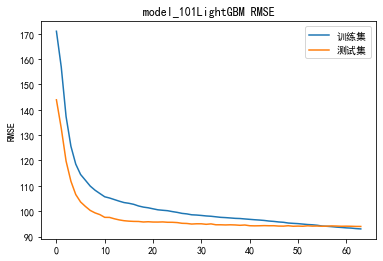

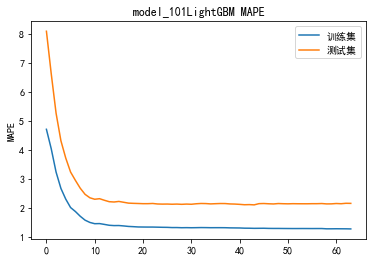

211364
*****Prediction for 销售区域: 102*****
[10]	training's rmse: 82.3552	training's mape: 1.37609	training's l2: 6782.38	valid_1's rmse: 65.2213	valid_1's mape: 1.67913	valid_1's l2: 4253.81
[20]	training's rmse: 77.8591	training's mape: 1.23556	training's l2: 6062.03	valid_1's rmse: 61.0005	valid_1's mape: 1.50854	valid_1's l2: 3721.06
[30]	training's rmse: 75.6811	training's mape: 1.19277	training's l2: 5727.63	valid_1's rmse: 58.9407	valid_1's mape: 1.45763	valid_1's l2: 3474.01
[40]	training's rmse: 74.2865	training's mape: 1.16698	training's l2: 5518.48	valid_1's rmse: 57.765	valid_1's mape: 1.43688	valid_1's l2: 3336.79
[50]	training's rmse: 73.1186	training's mape: 1.14782	training's l2: 5346.33	valid_1's rmse: 56.6603	valid_1's mape: 1.40942	valid_1's l2: 3210.39
[60]	training's rmse: 72.3722	training's mape: 1.14087	training's l2: 5237.73	valid_1's rmse: 56.0534	valid_1's mape: 1.4167	valid_1's l2: 3141.98
[70]	training's rmse: 71.6633	training's mape: 1.13157	training's l2: 51

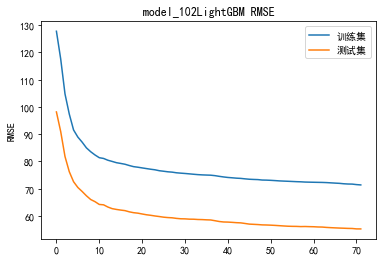

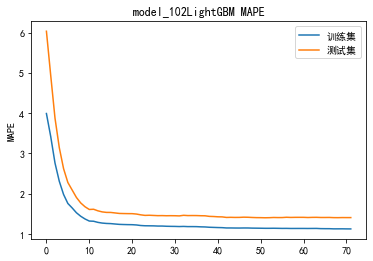

164107
*****Prediction for 销售区域: 103*****
[10]	training's rmse: 106.108	training's mape: 1.53427	training's l2: 11258.8	valid_1's rmse: 123.221	valid_1's mape: 2.53307	valid_1's l2: 15183.5
[20]	training's rmse: 101.288	training's mape: 1.37821	training's l2: 10259.4	valid_1's rmse: 118.816	valid_1's mape: 2.29611	valid_1's l2: 14117.3
[30]	training's rmse: 98.7145	training's mape: 1.3614	training's l2: 9744.55	valid_1's rmse: 116.995	valid_1's mape: 2.29293	valid_1's l2: 13687.9
[40]	training's rmse: 96.6276	training's mape: 1.33794	training's l2: 9336.89	valid_1's rmse: 116.191	valid_1's mape: 2.27824	valid_1's l2: 13500.3
[50]	training's rmse: 95.2861	training's mape: 1.3232	training's l2: 9079.44	valid_1's rmse: 115.49	valid_1's mape: 2.26609	valid_1's l2: 13337.9


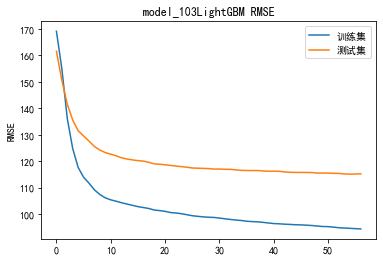

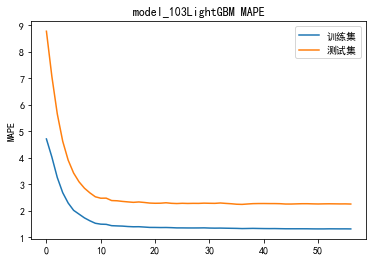

23229
*****Prediction for 销售区域: 104*****
221897
*****Prediction for 销售区域: 105*****
[10]	training's rmse: 99.2466	training's mape: 1.68717	training's l2: 9849.89	valid_1's rmse: 96.9502	valid_1's mape: 1.76885	valid_1's l2: 9399.34
[20]	training's rmse: 93.7537	training's mape: 1.49521	training's l2: 8789.75	valid_1's rmse: 93.771	valid_1's mape: 1.55421	valid_1's l2: 8793
[30]	training's rmse: 91.0291	training's mape: 1.45324	training's l2: 8286.3	valid_1's rmse: 92.5803	valid_1's mape: 1.53807	valid_1's l2: 8571.11
[40]	training's rmse: 89.1039	training's mape: 1.42428	training's l2: 7939.5	valid_1's rmse: 91.1778	valid_1's mape: 1.50008	valid_1's l2: 8313.39
[50]	training's rmse: 87.4152	training's mape: 1.39446	training's l2: 7641.42	valid_1's rmse: 91.0163	valid_1's mape: 1.49478	valid_1's l2: 8283.97
[60]	training's rmse: 86.3539	training's mape: 1.38905	training's l2: 7457	valid_1's rmse: 90.7885	valid_1's mape: 1.49204	valid_1's l2: 8242.55


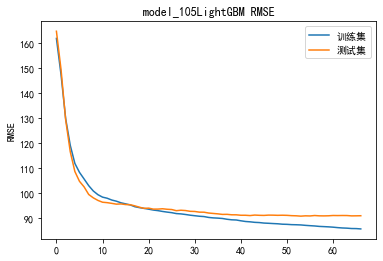

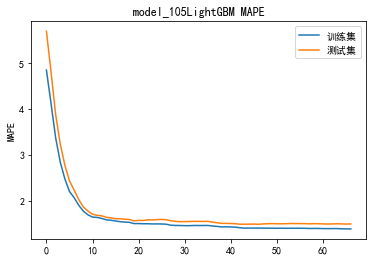

In [71]:


for store in states:
    try:
        df = data[data['销售区域编码']==store]
        print(len(df))

        #Split the data
        X_train, y_train = df[df['D']<1176].drop('订单需求量',axis=1), df[df['D']<1176]['订单需求量']
        X_valid, y_valid = df[(df['D']>=1176) & (df['D']<1208)].drop('订单需求量',axis=1), df[(df['D']>=1176) & (df['D']<1208)]['订单需求量']
        X_test = df[df['D']>=1208].drop('订单需求量',axis=1)

        #Train and validate
        model = LGBMRegressor(
            n_estimators=1000,
            learning_rate=0.3,
            subsample=0.8,
            colsample_bytree=0.8,
            max_depth=8,
            num_leaves=50,
            min_child_weight=300
        )
        print('*****Prediction for 销售区域: {}*****'.format(store))
        model.fit(X_train, y_train, eval_set=[(X_train,y_train),(X_valid,y_valid)],
                 eval_metric='rmse,mape', verbose=10, early_stopping_rounds=20)
        valid_preds[X_valid.index] = model.predict(X_valid)
        eval_preds[X_test.index] = model.predict(X_test)
        filename = "models/" + "model_"+ str(store) + ".pkl"
        # save model
        joblib.dump(model, filename)
#         print("ces:",model.evals_result_)
        plot_logloss(model,"model_"+ str(store))
   
        del model, X_train, y_train, X_valid, y_valid
    except:
        del model, X_train, y_train, X_valid, y_valid
        continue

## 挑选出101区域的模型进行模型验证：

In [72]:
model = joblib.load("models/model_101.pkl")
model

LGBMRegressor(colsample_bytree=0.8, learning_rate=0.3, max_depth=8,
              min_child_weight=300, n_estimators=1000, num_leaves=50,
              subsample=0.8)

In [73]:
df = data[data['销售区域编码']==101]
X_valid, y_valid = df[(df['D']>=1176) & (df['D']<1208)].drop('订单需求量',axis=1), df[(df['D']>=1176) & (df['D']<1208)]['订单需求量']
y_valid

570387     10
570388      7
570389      8
570390      6
570391      6
         ... 
596975     11
597322    199
597323     24
597324     15
597330      2
Name: 订单需求量, Length: 6057, dtype: int64

In [74]:
X_valid

,销售区域编码,产品编码,产品大类编码,产品细类编码,销售渠道名称,Year,Month,day,是否节假日,是否促销日,D,价格区间,每月时间段,season_bm,星期几,is_workday,need_lag_1,need_lag_2,need_lag_3,need_lag_6,need_lag_12,need_lag_24,need_lag_36,need_lag_48,need_lag_60,产品编码_avg,销售区域编码_need_avg,产品大类编码_need_avg,产品细类编码_need_avg,销售渠道名称_need_avg,销售区域编码_产品编码_need_avg,产品大类编码_产品编码_need_avg,产品细类编码_产品编码_need_avg,销售渠道名称_产品编码_need_avg,销售区域编码_产品大类编码_need_avg,产品大类编码_产品细类编码_need_avg,销售渠道名称_产品细类编码_need_avg,年_月_need_avg,年_销售区域编码_need_avg,年_产品大类编码_need_avg,年_产品细类编码_need_avg,年_销售渠道名称_need_avg,月_销售区域编码_need_avg,月_产品大类编码_need_avg,月_产品细类编码_need_avg,月_销售渠道名称_need_avg,每月时间段_销售区域编码_need_avg,价格区间_销售区域编码_need_avg,rolling_need_mean,expanding_need_mean,need_trend
570387,101,20253,306,407,0,2018,11,19,0,0,1176,1,1,2,0,1,180.0,204.0,10.0,470.0,45.0,4.0,30.0,503.0,324.0,150.750000,68.1875,85.87500,81.12500,61.0625,170.375000,150.750000,150.750000,150.750000,86.625000,81.12500,78.43750,66.500000,62.90625,77.06250,74.56250,53.0000,96.250,106.062500,96.375000,79.6875,74.375,112.500000,127.125000,194.250000,338.500000
570388,101,20131,306,407,0,2018,11,19,0,0,1176,2,1,2,0,1,2.0,6.0,5.0,3.0,10.0,9.0,5.0,235.0,10.0,47.625000,68.1875,85.87500,81.12500,61.0625,43.218750,47.625000,47.625000,47.812500,86.625000,81.12500,78.43750,66.500000,62.90625,77.06250,74.56250,53.0000,96.250,106.062500,96.375000,79.6875,74.375,90.625000,5.144531,49.187500,-36.218750
570389,101,20655,306,407,0,2018,11,19,0,0,1176,4,1,2,0,1,5.0,9.0,7.0,34.0,54.0,7.0,41.0,53.0,106.0,31.906250,68.1875,85.87500,81.12500,61.0625,32.781250,31.906250,31.906250,31.921875,86.625000,81.12500,78.43750,66.500000,62.90625,77.06250,74.56250,53.0000,96.250,106.062500,96.375000,79.6875,74.375,46.687500,11.289062,38.187500,-25.281250
570390,101,20346,306,407,0,2018,11,19,0,0,1176,2,1,2,0,1,5.0,9.0,3.0,58.0,207.0,102.0,272.0,8.0,51.0,70.250000,68.1875,85.87500,81.12500,61.0625,78.000000,70.250000,70.250000,70.250000,86.625000,81.12500,78.43750,66.500000,62.90625,77.06250,74.56250,53.0000,96.250,106.062500,96.375000,79.6875,74.375,90.625000,28.578125,86.562500,-5.687500
570391,101,20775,306,407,0,2018,11,19,0,0,1176,6,1,2,0,1,15.0,19.0,11.0,7.0,12.0,28.0,NaN,NaN,NaN,5.316406,68.1875,85.87500,81.12500,61.0625,10.632812,5.316406,5.316406,5.316406,86.625000,81.12500,78.43750,66.500000,62.90625,77.06250,74.56250,53.0000,96.250,106.062500,96.375000,79.6875,74.375,17.890625,17.000000,17.437500,10.117188
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
596975,101,21644,303,401,1,2018,12,20,0,0,1207,0,1,3,3,1,159.0,7.0,38.0,38.0,64.0,53.0,107.0,41.0,37.0,58.031250,68.1875,35.68750,42.21875,85.0625,65.437500,58.031250,58.031250,88.062500,34.093750,42.21875,63.34375,13.234375,62.90625,36.75000,45.81250,91.1875,48.875,21.125000,25.375000,47.8125,74.375,128.000000,66.000000,70.250000,-6.437500
597322,101,20693,308,404,0,2018,12,20,0,0,1207,2,1,3,3,1,72.0,1.0,25.0,5.0,58.0,103.0,305.0,77.0,17.0,236.500000,68.1875,86.75000,86.75000,61.0625,270.000000,236.500000,236.500000,237.375000,90.562500,86.75000,82.81250,13.234375,62.90625,85.87500,85.87500,53.0000,48.875,69.375000,69.375000,48.2500,74.375,90.625000,73.687500,305.500000,-71.000000
597323,101,20803,304,409,0,2018,12,20,0,0,1207,6,1,3,3,1,52.0,27.0,103.0,13.0,39.0,19.0,10.0,NaN,NaN,45.906250,68.1875,40.59375,40.59375,61.0625,19.421875,45.906250,45.906250,45.968750,7.203125,40.59375,48.50000,13.234375,62.90625,43.34375,43.34375,53.0000,48.875,24.109375,24.109375,48.2500,74.375,17.890625,51.000000,36.781250,14.921875
597324,101,22015,304,409,0,2018,12,20,0,0,1207,6,1,3,3,1,14.0,41.0,42.0,21.0,25.0,8.0,8.0,20.0,33.0,18.062500,68.1875,40.59375,40.59375,61.0625,12.351562,18.062500,18.062500,18.062500,7.203125,40.59375,48.50000,13.234375,62.90625,43.34375,43.34375,53.0000,48.875,24.109375,24.109375,48.2500,74.375,17.890625,23.421875,18.750000,2.148438


In [75]:
s = model.predict(X_valid)
s

array([281.00227817,   7.88994909,   8.0526942 , ...,  41.11807771,
        20.36157408,   5.8569909 ])

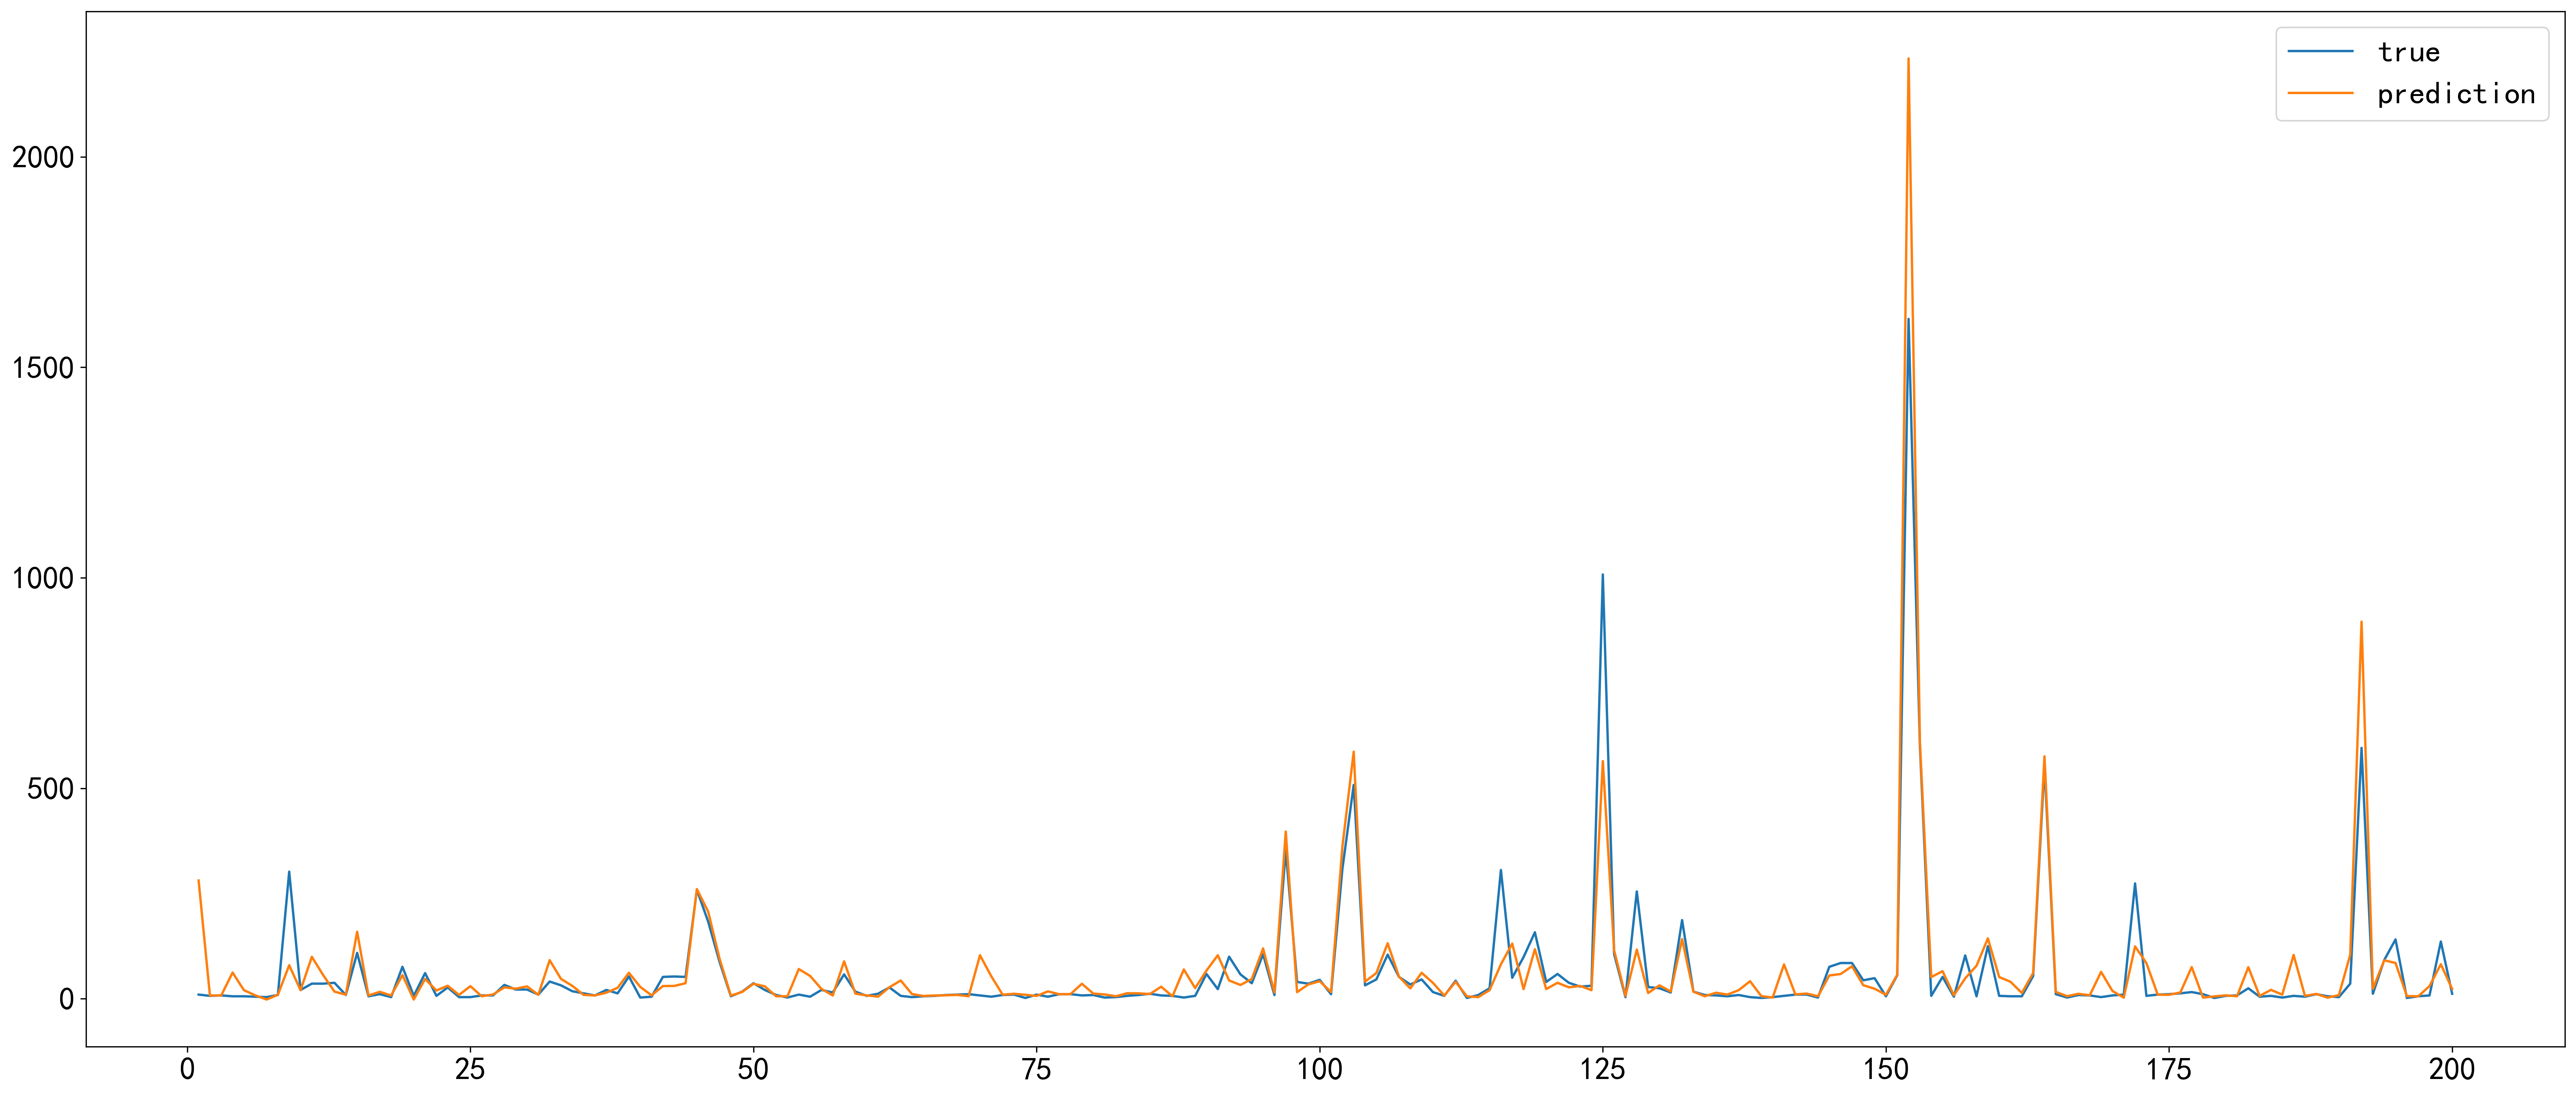

In [76]:
x_axis=np.linspace(1,len(y_valid),len(y_valid))
font1 = {'family' : 'SimSun','weight' : 'normal','size'   : 20,}
colors =['black','green','yellow','blue','cyan','red','orange','pink']
plt.figure(dpi=300,figsize=(28,12))


plt.plot(x_axis[:200],y_valid[:200])
plt.plot(x_axis[:200],s[:200])
plt.legend(['true','prediction'],prop = {'size':20})
# plt.scatter(x_data,y_data_yuemo,color='blue')
plt.tick_params(labelsize=20)  #修改刻度显示大小

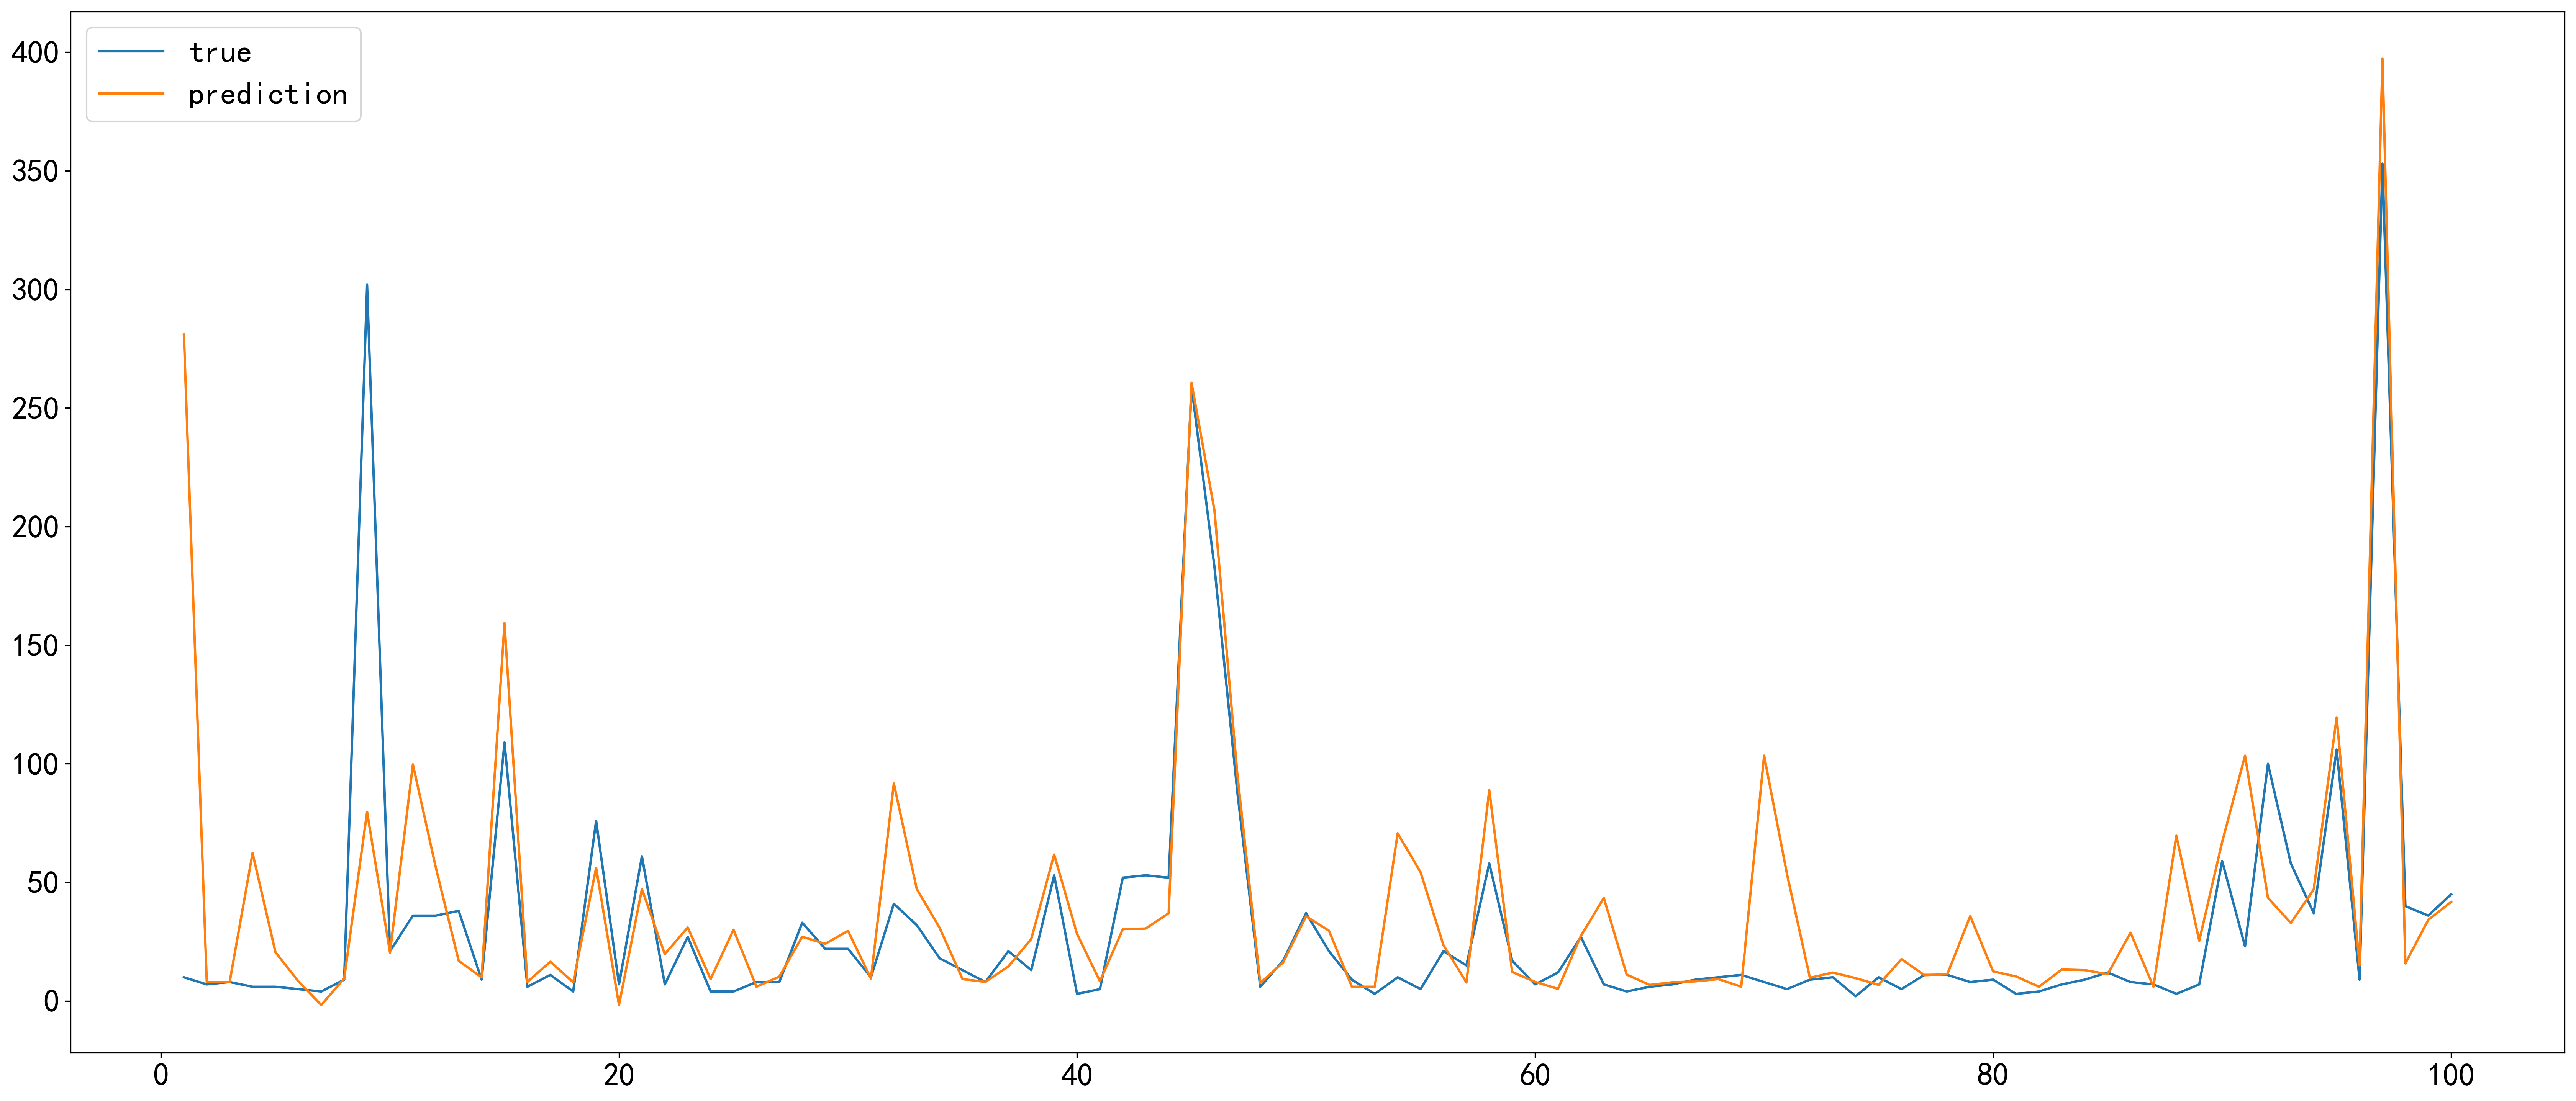

In [77]:
x_axis=np.linspace(1,len(y_valid),len(y_valid))
font1 = {'family' : 'SimSun','weight' : 'normal','size'   : 20,}
colors =['black','green','yellow','blue','cyan','red','orange','pink']
plt.figure(dpi=300,figsize=(28,12))


plt.plot(x_axis[:100],y_valid[:100])
plt.plot(x_axis[:100],s[:100])
plt.legend(['true','prediction'],prop = {'size':20})
# plt.scatter(x_data,y_data_yuemo,color='blue')
plt.tick_params(labelsize=20)  #修改刻度显示大小

In [78]:
eval_preds  ##y预测出来的值

597361     5.321415
597362     6.536041
597363     4.506921
597364    11.020315
597365     2.781325
            ...    
811934     4.936509
811935     7.631538
811936     7.501898
811937     8.478031
811938     5.438099
Name: 订单需求量, Length: 214578, dtype: float64

## 查看模型特征重要性，验证我们前期特征工程

In [79]:
model = joblib.load("models/model_105.pkl")
s = model.feature_importances_
s 
len(s)

features = [f for f in data.columns if f != '订单需求量']
len(features)

51

.ipynb_checkpoints
model_101.pkl
model_102.pkl
model_103.pkl
model_104.pkl
model_105.pkl


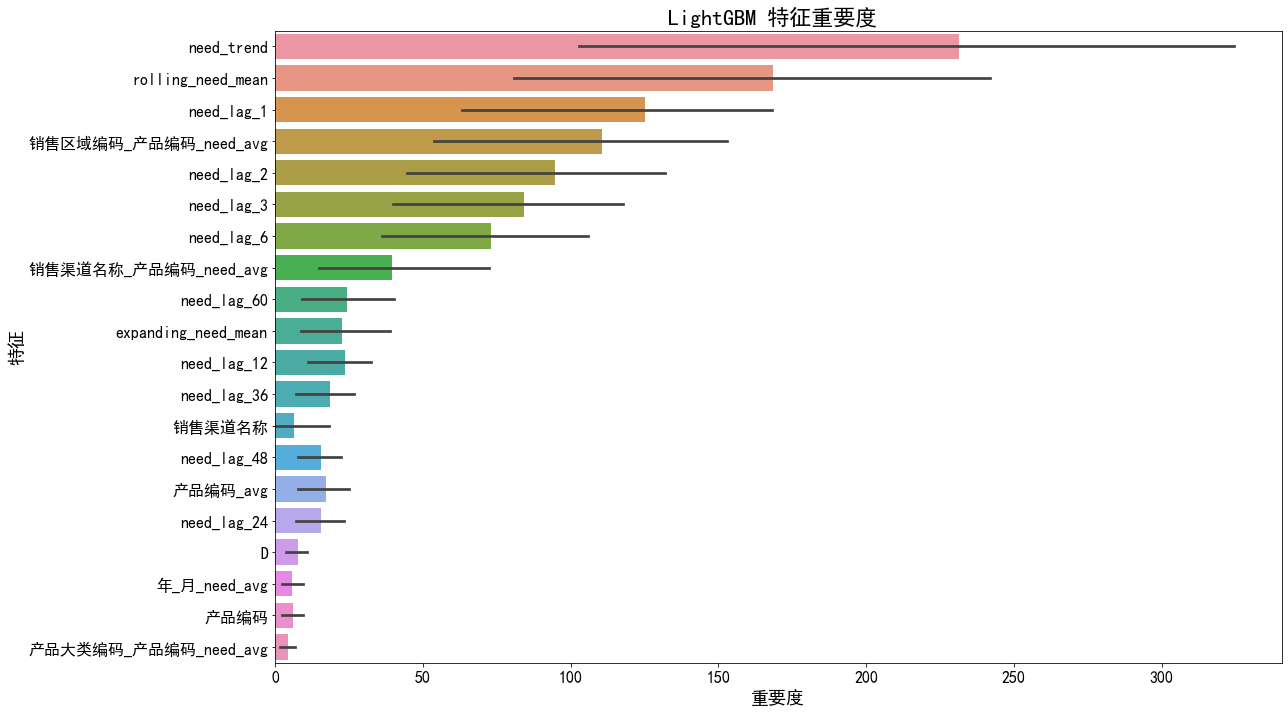

In [80]:
import os
feature_importance_df = pd.DataFrame()
features = [f for f in data.columns if f != '订单需求量']
# print(features)
for filename in os.listdir('./models'):
    print(filename)
    if 'model' in filename:
        # load model
        model = joblib.load("models/"+filename) 
        store_importance_df = pd.DataFrame()
        store_importance_df["特征"] = features
        store_importance_df["重要度"] = model.feature_importances_
        
        store_importance_df["store"] = filename[5:9]
        feature_importance_df = pd.concat([feature_importance_df, store_importance_df], axis=0)
        del model
    
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["特征", "重要度"]].groupby("特征").mean().sort_values(by="重要度", ascending=False)[:20].index
    best_features = feature_importance_df_.loc[feature_importance_df_.特征.isin(cols)]
    plt.figure(figsize=(18, 10))
    sns.barplot(x="重要度", y="特征", data=best_features.sort_values(by="重要度", ascending=False))
    plt.title('LightGBM 特征重要度 ',fontsize=22)
    plt.xlabel('重要度',fontsize=18)
    plt.ylabel('特征',fontsize=18)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    #plt.savefig('特征重要度.jpg',dpi=100)
    plt.tight_layout()
    
display_importances(feature_importance_df)

# 预测样例数据结果

## 读取之前构造好的19年1月数据

In [81]:
result=[]
for v in eval_preds:
    if v<0:
        result.append(0)  #预测值里有负值，这是不可能的，所有我们用0来代表异常值，
    else:
        result.append(round(v,0))
# result

In [82]:
## d读取之前构造好的19年1月数据：
df_sub= pd.read_csv('data/构造19_01data.csv')
df_sub

,订单日期,销售区域编码,产品编码,产品大类编码,产品细类编码,销售渠道名称,订单需求量,Year,Month,day,是否节假日,是否促销日,D,价格区间,每月时间段,season_bm,星期几,is_workday
0,2018-12-21,102,21023,306,407,0,0,2018,12,21,0,0,1208,6,2,3,4,1
1,2018-12-21,101,20877,308,404,0,0,2018,12,21,0,0,1208,2,2,3,4,1
2,2018-12-21,105,20347,308,404,0,0,2018,12,21,0,0,1208,2,2,3,4,1
3,2018-12-21,102,20173,303,401,1,0,2018,12,21,0,0,1208,1,2,3,4,1
4,2018-12-21,101,20285,305,412,1,0,2018,12,21,0,0,1208,0,2,3,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214573,2019-01-31,103,20135,303,401,0,0,2019,1,31,0,0,1249,2,2,3,3,1
214574,2019-01-31,105,20171,302,408,1,0,2019,1,31,0,0,1249,6,2,3,3,1
214575,2019-01-31,105,20093,306,407,0,0,2019,1,31,0,0,1249,2,2,3,3,1
214576,2019-01-31,103,21895,308,404,0,0,2019,1,31,0,0,1249,6,2,3,3,1


## 将预测的各产品一月需求量值进行替换

In [83]:
df_sub['订单需求量'] = result  #把预测的订单需求量替换
df_sub.to_csv('output/构造的1月数据预测结果.csv',index=False)
df_sub

,订单日期,销售区域编码,产品编码,产品大类编码,产品细类编码,销售渠道名称,订单需求量,Year,Month,day,是否节假日,是否促销日,D,价格区间,每月时间段,season_bm,星期几,is_workday
0,2018-12-21,102,21023,306,407,0,5.0,2018,12,21,0,0,1208,6,2,3,4,1
1,2018-12-21,101,20877,308,404,0,7.0,2018,12,21,0,0,1208,2,2,3,4,1
2,2018-12-21,105,20347,308,404,0,5.0,2018,12,21,0,0,1208,2,2,3,4,1
3,2018-12-21,102,20173,303,401,1,11.0,2018,12,21,0,0,1208,1,2,3,4,1
4,2018-12-21,101,20285,305,412,1,3.0,2018,12,21,0,0,1208,0,2,3,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214573,2019-01-31,103,20135,303,401,0,5.0,2019,1,31,0,0,1249,2,2,3,3,1
214574,2019-01-31,105,20171,302,408,1,8.0,2019,1,31,0,0,1249,6,2,3,3,1
214575,2019-01-31,105,20093,306,407,0,8.0,2019,1,31,0,0,1249,2,2,3,3,1
214576,2019-01-31,103,21895,308,404,0,8.0,2019,1,31,0,0,1249,6,2,3,3,1


In [84]:
result_df1=df_sub.loc[df_sub['D']>=1219]  #定位到19年1月的数据
result_df1

,订单日期,销售区域编码,产品编码,产品大类编码,产品细类编码,销售渠道名称,订单需求量,Year,Month,day,是否节假日,是否促销日,D,价格区间,每月时间段,season_bm,星期几,is_workday
56199,2019-01-01,102,21023,306,407,0,5.0,2019,1,1,1,1,1219,6,0,3,1,0
56200,2019-01-01,101,20877,308,404,0,6.0,2019,1,1,1,1,1219,2,0,3,1,0
56201,2019-01-01,105,20347,308,404,0,6.0,2019,1,1,1,1,1219,2,0,3,1,0
56202,2019-01-01,102,20173,303,401,1,5.0,2019,1,1,1,1,1219,1,0,3,1,0
56203,2019-01-01,101,20285,305,412,1,3.0,2019,1,1,1,1,1219,0,0,3,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214573,2019-01-31,103,20135,303,401,0,5.0,2019,1,31,0,0,1249,2,2,3,3,1
214574,2019-01-31,105,20171,302,408,1,8.0,2019,1,31,0,0,1249,6,2,3,3,1
214575,2019-01-31,105,20093,306,407,0,8.0,2019,1,31,0,0,1249,2,2,3,3,1
214576,2019-01-31,103,21895,308,404,0,8.0,2019,1,31,0,0,1249,6,2,3,3,1


In [85]:
result_df = result_df1[['订单日期','销售区域编码','产品编码','产品大类编码','产品细类编码','订单需求量']]  #筛选出需要的列

result_df

,订单日期,销售区域编码,产品编码,产品大类编码,产品细类编码,订单需求量
56199,2019-01-01,102,21023,306,407,5.0
56200,2019-01-01,101,20877,308,404,6.0
56201,2019-01-01,105,20347,308,404,6.0
56202,2019-01-01,102,20173,303,401,5.0
56203,2019-01-01,101,20285,305,412,3.0
...,...,...,...,...,...,...
214573,2019-01-31,103,20135,303,401,5.0
214574,2019-01-31,105,20171,302,408,8.0
214575,2019-01-31,105,20093,306,407,8.0
214576,2019-01-31,103,21895,308,404,8.0


## 制作透视表，计算各产品一月的总需求量

In [86]:
#制作透视表得到所有产品19年1月的需求量
result_df = pd.pivot_table(result_df, index=['销售区域编码','产品大类编码','产品细类编码','产品编码'], columns='订单日期',
                                  values='订单需求量', aggfunc=np.sum,fill_value=1).reset_index()
result_df

订单日期,销售区域编码,产品大类编码,产品细类编码,产品编码,2019-01-01,2019-01-02,2019-01-03,2019-01-04,2019-01-05,2019-01-06,2019-01-07,2019-01-08,2019-01-09,2019-01-10,2019-01-11,2019-01-12,2019-01-13,2019-01-14,2019-01-15,2019-01-16,2019-01-17,2019-01-18,2019-01-19,2019-01-20,2019-01-21,2019-01-22,2019-01-23,2019-01-24,2019-01-25,2019-01-26,2019-01-27,2019-01-28,2019-01-29,2019-01-30,2019-01-31
0,101,301,405,20003,15,15,15,15,17,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,16,15,15
1,101,301,405,20027,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,6,6,6,6,6,6,6,6,6,6,6,6,6,6
2,101,301,405,20085,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,5,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6
3,101,301,405,20219,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,7,5,5,5,5,5,5,5,5,5,5,5,5
4,101,301,405,20270,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5104,105,308,404,21981,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5
5105,105,308,404,22005,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6
5106,105,308,404,22018,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5
5107,105,308,404,22023,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8


In [87]:
result_df.iloc[:,4:]

订单日期,2019-01-01,2019-01-02,2019-01-03,2019-01-04,2019-01-05,2019-01-06,2019-01-07,2019-01-08,2019-01-09,2019-01-10,2019-01-11,2019-01-12,2019-01-13,2019-01-14,2019-01-15,2019-01-16,2019-01-17,2019-01-18,2019-01-19,2019-01-20,2019-01-21,2019-01-22,2019-01-23,2019-01-24,2019-01-25,2019-01-26,2019-01-27,2019-01-28,2019-01-29,2019-01-30,2019-01-31
0,15,15,15,15,17,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,16,15,15
1,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,6,6,6,6,6,6,6,6,6,6,6,6,6,6
2,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,5,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6
3,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,7,5,5,5,5,5,5,5,5,5,5,5,5
4,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5104,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5
5105,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6
5106,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5
5107,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8


In [88]:
result_df['1月总需求量'] = result_df.iloc[:,4:].sum(axis=1)  # 对0，1列按行求和，生成新列
result_df


订单日期,销售区域编码,产品大类编码,产品细类编码,产品编码,2019-01-01,2019-01-02,2019-01-03,2019-01-04,2019-01-05,2019-01-06,2019-01-07,2019-01-08,2019-01-09,2019-01-10,2019-01-11,2019-01-12,2019-01-13,2019-01-14,2019-01-15,2019-01-16,2019-01-17,2019-01-18,2019-01-19,2019-01-20,2019-01-21,2019-01-22,2019-01-23,2019-01-24,2019-01-25,2019-01-26,2019-01-27,2019-01-28,2019-01-29,2019-01-30,2019-01-31,1月总需求量
0,101,301,405,20003,15,15,15,15,17,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,16,15,15,468
1,101,301,405,20027,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,6,6,6,6,6,6,6,6,6,6,6,6,6,6,169
2,101,301,405,20085,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,5,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,185
3,101,301,405,20219,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,7,5,5,5,5,5,5,5,5,5,5,5,5,157
4,101,301,405,20270,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,186
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5104,105,308,404,21981,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,155
5105,105,308,404,22005,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,186
5106,105,308,404,22018,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,155
5107,105,308,404,22023,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,248


In [89]:
result_df = result_df[['销售区域编码','产品大类编码','产品细类编码','产品编码','1月总需求量']]
result_df

订单日期,销售区域编码,产品大类编码,产品细类编码,产品编码,1月总需求量
0,101,301,405,20003,468
1,101,301,405,20027,169
2,101,301,405,20085,185
3,101,301,405,20219,157
4,101,301,405,20270,186
...,...,...,...,...,...
5104,105,308,404,21981,155
5105,105,308,404,22005,186
5106,105,308,404,22018,155
5107,105,308,404,22023,248


## 求每种产销售区域编码-品大类编码-产品细类编码的预测需求量的均值，作为新产品的预测值

In [90]:
new = result_df[['销售区域编码','产品大类编码','产品细类编码','1月总需求量']].groupby(['销售区域编码','产品大类编码','产品细类编码',]).mean().reset_index()
new

订单日期,销售区域编码,产品大类编码,产品细类编码,1月总需求量
0,101,301,405,194.833333
1,101,302,408,192.087452
2,101,303,401,198.771605
3,101,303,406,185.142857
4,101,303,410,179.230769
5,101,303,411,183.428571
6,101,304,409,213.791667
7,101,305,412,176.946746
8,101,306,402,411.571429
9,101,306,407,197.786432


## 读入predict_sku1.csv，进行匹配汇总，得到结果

In [91]:
# 读入predict_sku0.csv，进行匹配汇总，predict_sku0中的产品的1月需求量：
predict_df = pd.read_csv("../B题-全部数据//predict_sku1.csv")
predict_df.columns =['销售区域编码','产品编码','产品大类编码','产品细类编码',]
predict_df

,销售区域编码,产品编码,产品大类编码,产品细类编码
0,101,20002,303,406
1,101,20003,301,405
2,101,20006,307,403
3,101,20011,303,401
4,101,20014,307,403
...,...,...,...,...
2614,105,22066,307,403
2615,105,22072,305,412
2616,105,22075,307,403
2617,105,22083,303,401


In [92]:
#测试，查看predict_sku1中的新产品
#CESHI

result_df['zuhe'] = result_df['销售区域编码'].astype(str)+'_'+result_df['产品大类编码'].astype(str)+'_'+result_df['产品细类编码'].astype(str)+'_'+result_df['产品编码'].astype(str)
result_df 

predict_df['zuhe'] = predict_df['销售区域编码'].astype(str)+'_'+predict_df['产品大类编码'].astype(str)+'_'+predict_df['产品细类编码'].astype(str)+'_'+predict_df['产品编码'].astype(str)
predict_df

,销售区域编码,产品编码,产品大类编码,产品细类编码,zuhe
0,101,20002,303,406,101_303_406_20002
1,101,20003,301,405,101_301_405_20003
2,101,20006,307,403,101_307_403_20006
3,101,20011,303,401,101_303_401_20011
4,101,20014,307,403,101_307_403_20014
...,...,...,...,...,...
2614,105,22066,307,403,105_307_403_22066
2615,105,22072,305,412,105_305_412_22072
2616,105,22075,307,403,105_307_403_22075
2617,105,22083,303,401,105_303_401_22083


In [93]:
ls = list(result_df['zuhe'])
ls 
count =0 
for v in predict_df['zuhe']:
    if v not in ls: 
        
#         print(v)
        count+=1
print("新产品",count)
        

新产品 432


In [94]:
predict_df

,销售区域编码,产品编码,产品大类编码,产品细类编码,zuhe
0,101,20002,303,406,101_303_406_20002
1,101,20003,301,405,101_301_405_20003
2,101,20006,307,403,101_307_403_20006
3,101,20011,303,401,101_303_401_20011
4,101,20014,307,403,101_307_403_20014
...,...,...,...,...,...
2614,105,22066,307,403,105_307_403_22066
2615,105,22072,305,412,105_305_412_22072
2616,105,22075,307,403,105_307_403_22075
2617,105,22083,303,401,105_303_401_22083


In [95]:
result_df 

订单日期,销售区域编码,产品大类编码,产品细类编码,产品编码,1月总需求量,zuhe
0,101,301,405,20003,468,101_301_405_20003
1,101,301,405,20027,169,101_301_405_20027
2,101,301,405,20085,185,101_301_405_20085
3,101,301,405,20219,157,101_301_405_20219
4,101,301,405,20270,186,101_301_405_20270
...,...,...,...,...,...,...
5104,105,308,404,21981,155,105_308_404_21981
5105,105,308,404,22005,186,105_308_404_22005
5106,105,308,404,22018,155,105_308_404_22018
5107,105,308,404,22023,248,105_308_404_22023


In [96]:
s=pd.merge(predict_df,result_df,how='left')
s.drop('zuhe',axis=1,inplace=True)

s 

,销售区域编码,产品编码,产品大类编码,产品细类编码,1月总需求量
0,101,20002,303,406,186.0
1,101,20003,301,405,468.0
2,101,20006,307,403,184.0
3,101,20011,303,401,NaN
4,101,20014,307,403,60.0
...,...,...,...,...,...
2614,105,22066,307,403,536.0
2615,105,22072,305,412,279.0
2616,105,22075,307,403,NaN
2617,105,22083,303,401,307.0


## 将新产品以预测同类型的产品的均值填充

In [97]:
t =new.loc[(new['销售区域编码']==101)&(new['产品大类编码']==303)&(new['产品细类编码']==401)]['1月总需求量']
t 

2    198.771605
Name: 1月总需求量, dtype: float64

In [98]:
xuqiu = []
for index,row in s.iterrows():
    if np.isnan(row['1月总需求量']):
#         print( row['1月总需求量'])
        
        t=int(new.loc[(new['销售区域编码']==row['销售区域编码'])&(new['产品大类编码']==row['产品大类编码'])&(new['产品细类编码']==row['产品细类编码'])]['1月总需求量'])
        xuqiu.append(t)
    else:
        xuqiu.append(int(row['1月总需求量']))
s['1月总需求量'] = xuqiu
s 

,销售区域编码,产品编码,产品大类编码,产品细类编码,1月总需求量
0,101,20002,303,406,186
1,101,20003,301,405,468
2,101,20006,307,403,184
3,101,20011,303,401,198
4,101,20014,307,403,60
...,...,...,...,...,...
2614,105,22066,307,403,536
2615,105,22072,305,412,279
2616,105,22075,307,403,210
2617,105,22083,303,401,307


## 保存预测数据

In [99]:
s.to_csv('output/样本数据预测的1月predict_sku1.csv',index=False)